# NIH Chest X-Ray Dataset

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
sns.set_style('whitegrid')

import tensorflow
gpu_available = tensorflow.config.list_physical_devices('GPU')
if gpu_available:
    print("GPU is available!")
    device = "/GPU:0"  # Use GPU
else:
    print("GPU is not available. Using CPU.")
    device = "/CPU:0"  # Use CPU

# Optionally set the device for operations
with tensorflow.device(device):
    # Example TensorFlow operation
    a = tensorflow.constant([[1.0, 2.0], [3.0, 4.0]])
    b = tensorflow.constant([[5.0, 6.0], [7.0, 8.0]])
    c = tensorflow.matmul(a, b)
    print("Result:", c.numpy())

GPU is not available. Using CPU.
Result: [[19. 22.]
 [43. 50.]]


In [4]:
xray_dataset = pd.read_csv('../Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('..', 'images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', xray_dataset.shape[0])
xray_dataset['path'] = xray_dataset['Image Index'].map(all_image_paths.get)
xray_dataset = xray_dataset.drop(['Unnamed: 11'], axis = 1)
xray_dataset = xray_dataset.rename(columns = {'OriginalImage[Width': 'Ori_Image_w',
                       'Height]': 'Ori_Image_h',
                       'OriginalImagePixelSpacing[x': 'Ori_Image_Pixel_Spacing_x', 
                       'y]': 'Ori_Image_Pixel_Spacing_y'
                       })

xray_dataset.attrs['Name'] = 'Data_Entry_2017.csv'
xray_dataset.sample(3)

print(xray_dataset.dtypes)

Scans found: 112120 , Total Headers 112120
Image Index                   object
Finding Labels                object
Follow-up #                    int64
Patient ID                     int64
Patient Age                    int64
Patient Gender                object
View Position                 object
Ori_Image_w                    int64
Ori_Image_h                    int64
Ori_Image_Pixel_Spacing_x    float64
Ori_Image_Pixel_Spacing_y    float64
path                          object
dtype: object


## EDA

In [5]:
print(xray_dataset.shape)
xray_dataset.describe()

(112120, 12)


Follow-up #     Patient ID    Patient Age    Ori_Image_w  \
count  112120.000000  112120.000000  112120.000000  112120.000000   
mean        8.573751   14346.381743      46.901463    2646.078844   
std        15.406320    8403.876972      16.839923     341.246429   
min         0.000000       1.000000       1.000000    1143.000000   
25%         0.000000    7310.750000      35.000000    2500.000000   
50%         3.000000   13993.000000      49.000000    2518.000000   
75%        10.000000   20673.000000      59.000000    2992.000000   
max       183.000000   30805.000000     414.000000    3827.000000   

         Ori_Image_h  Ori_Image_Pixel_Spacing_x  Ori_Image_Pixel_Spacing_y  
count  112120.000000              112120.000000              112120.000000  
mean     2486.438842                   0.155649                   0.155649  
std       401.268227                   0.016174                   0.016174  
min       966.000000                   0.115000                   0.115000  
25%      2048.000000                   0.143000                   0.143000  
50%      2544.000000                   0.143000                   0.143000  
75%      2991.000000                   0.168000                   0.168000  
max      4715.000000                   0.198800                   0.198800

In [6]:
# rows having no. of disease
xray_dataset['Disease_Count'] = xray_dataset['Finding Labels'].apply(lambda text: len(text.split('|')) if(text != 'No Finding') else 0)

### Age Distribution

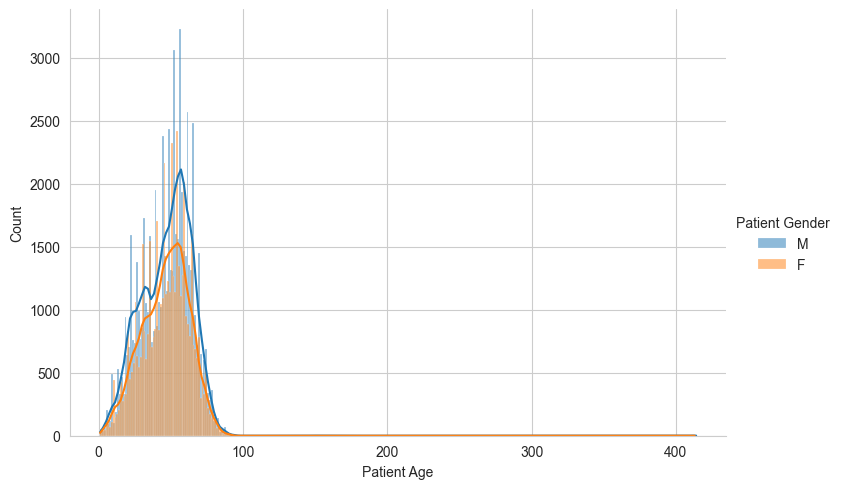

Number of patients with age greater than 100: 16


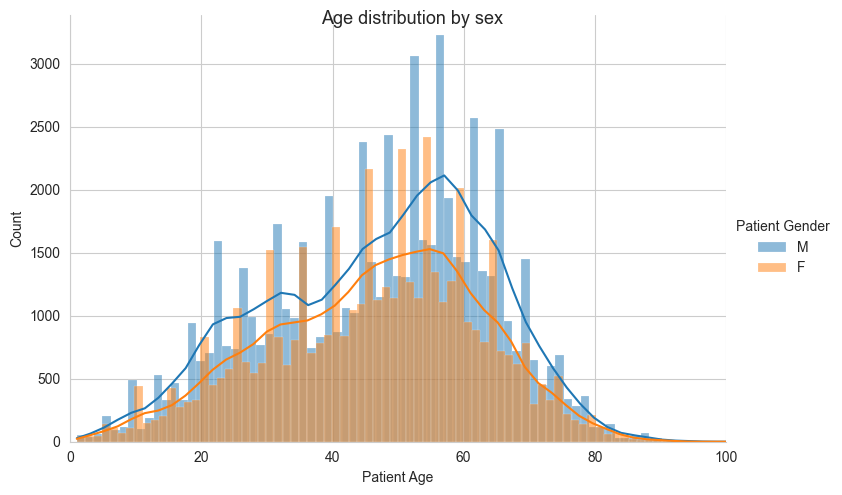

In [7]:
sns.FacetGrid(xray_dataset, hue='Patient Gender', height=5, aspect=1.5).map(sns.histplot, 'Patient Age', kde=True).add_legend()
plt.show()
# Count of ages greater than 100
age_greater_than_100 = (xray_dataset['Patient Age'] > 100).sum()

print(f"Number of patients with age greater than 100: {age_greater_than_100}")

g = sns.FacetGrid(xray_dataset, hue='Patient Gender', height=5, aspect=1.5)
g.map(sns.histplot, 'Patient Age', kde=True).add_legend()
g.set(xlim=(0, 100))  # Set the x-axis limits to 0–100
g.fig.suptitle('Age distribution by sex',fontsize=13)
plt.show()


### Disease Distribution

In [8]:
# xray_dataset['Finding Labels'] = xray_dataset['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*xray_dataset['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        xray_dataset[c_label] = xray_dataset['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
xray_dataset.sample(3)

All Labels (15): [np.str_('Atelectasis'), np.str_('Cardiomegaly'), np.str_('Consolidation'), np.str_('Edema'), np.str_('Effusion'), np.str_('Emphysema'), np.str_('Fibrosis'), np.str_('Hernia'), np.str_('Infiltration'), np.str_('Mass'), np.str_('No Finding'), np.str_('Nodule'), np.str_('Pleural_Thickening'), np.str_('Pneumonia'), np.str_('Pneumothorax')]


Image Index         Finding Labels  Follow-up #  Patient ID  \
54254  00013628_001.png             No Finding            1       13628   
23391  00006199_017.png             No Finding           17        6199   
88207  00021821_001.png  Effusion|Infiltration            1       21821   

       Patient Age Patient Gender View Position  Ori_Image_w  Ori_Image_h  \
54254           45              M            PA         3056         2544   
23391           60              M            PA         2898         2905   
88207           52              M            AP         3056         2544   

       Ori_Image_Pixel_Spacing_x  ...  Emphysema Fibrosis  Hernia  \
54254                      0.139  ...        0.0      0.0     0.0   
23391                      0.143  ...        0.0      0.0     0.0   
88207                      0.139  ...        0.0      0.0     0.0   

       Infiltration  Mass  No Finding  Nodule  Pleural_Thickening  Pneumonia  \
54254           0.0   0.0         1.0     0.0                 0.0        0.0   
23391           0.0   0.0         1.0     0.0                 0.0        0.0   
88207           1.0   0.0         0.0     0.0                 0.0        0.0   

       Pneumothorax  
54254           0.0  
23391           0.0  
88207           0.0  

[3 rows x 28 columns]

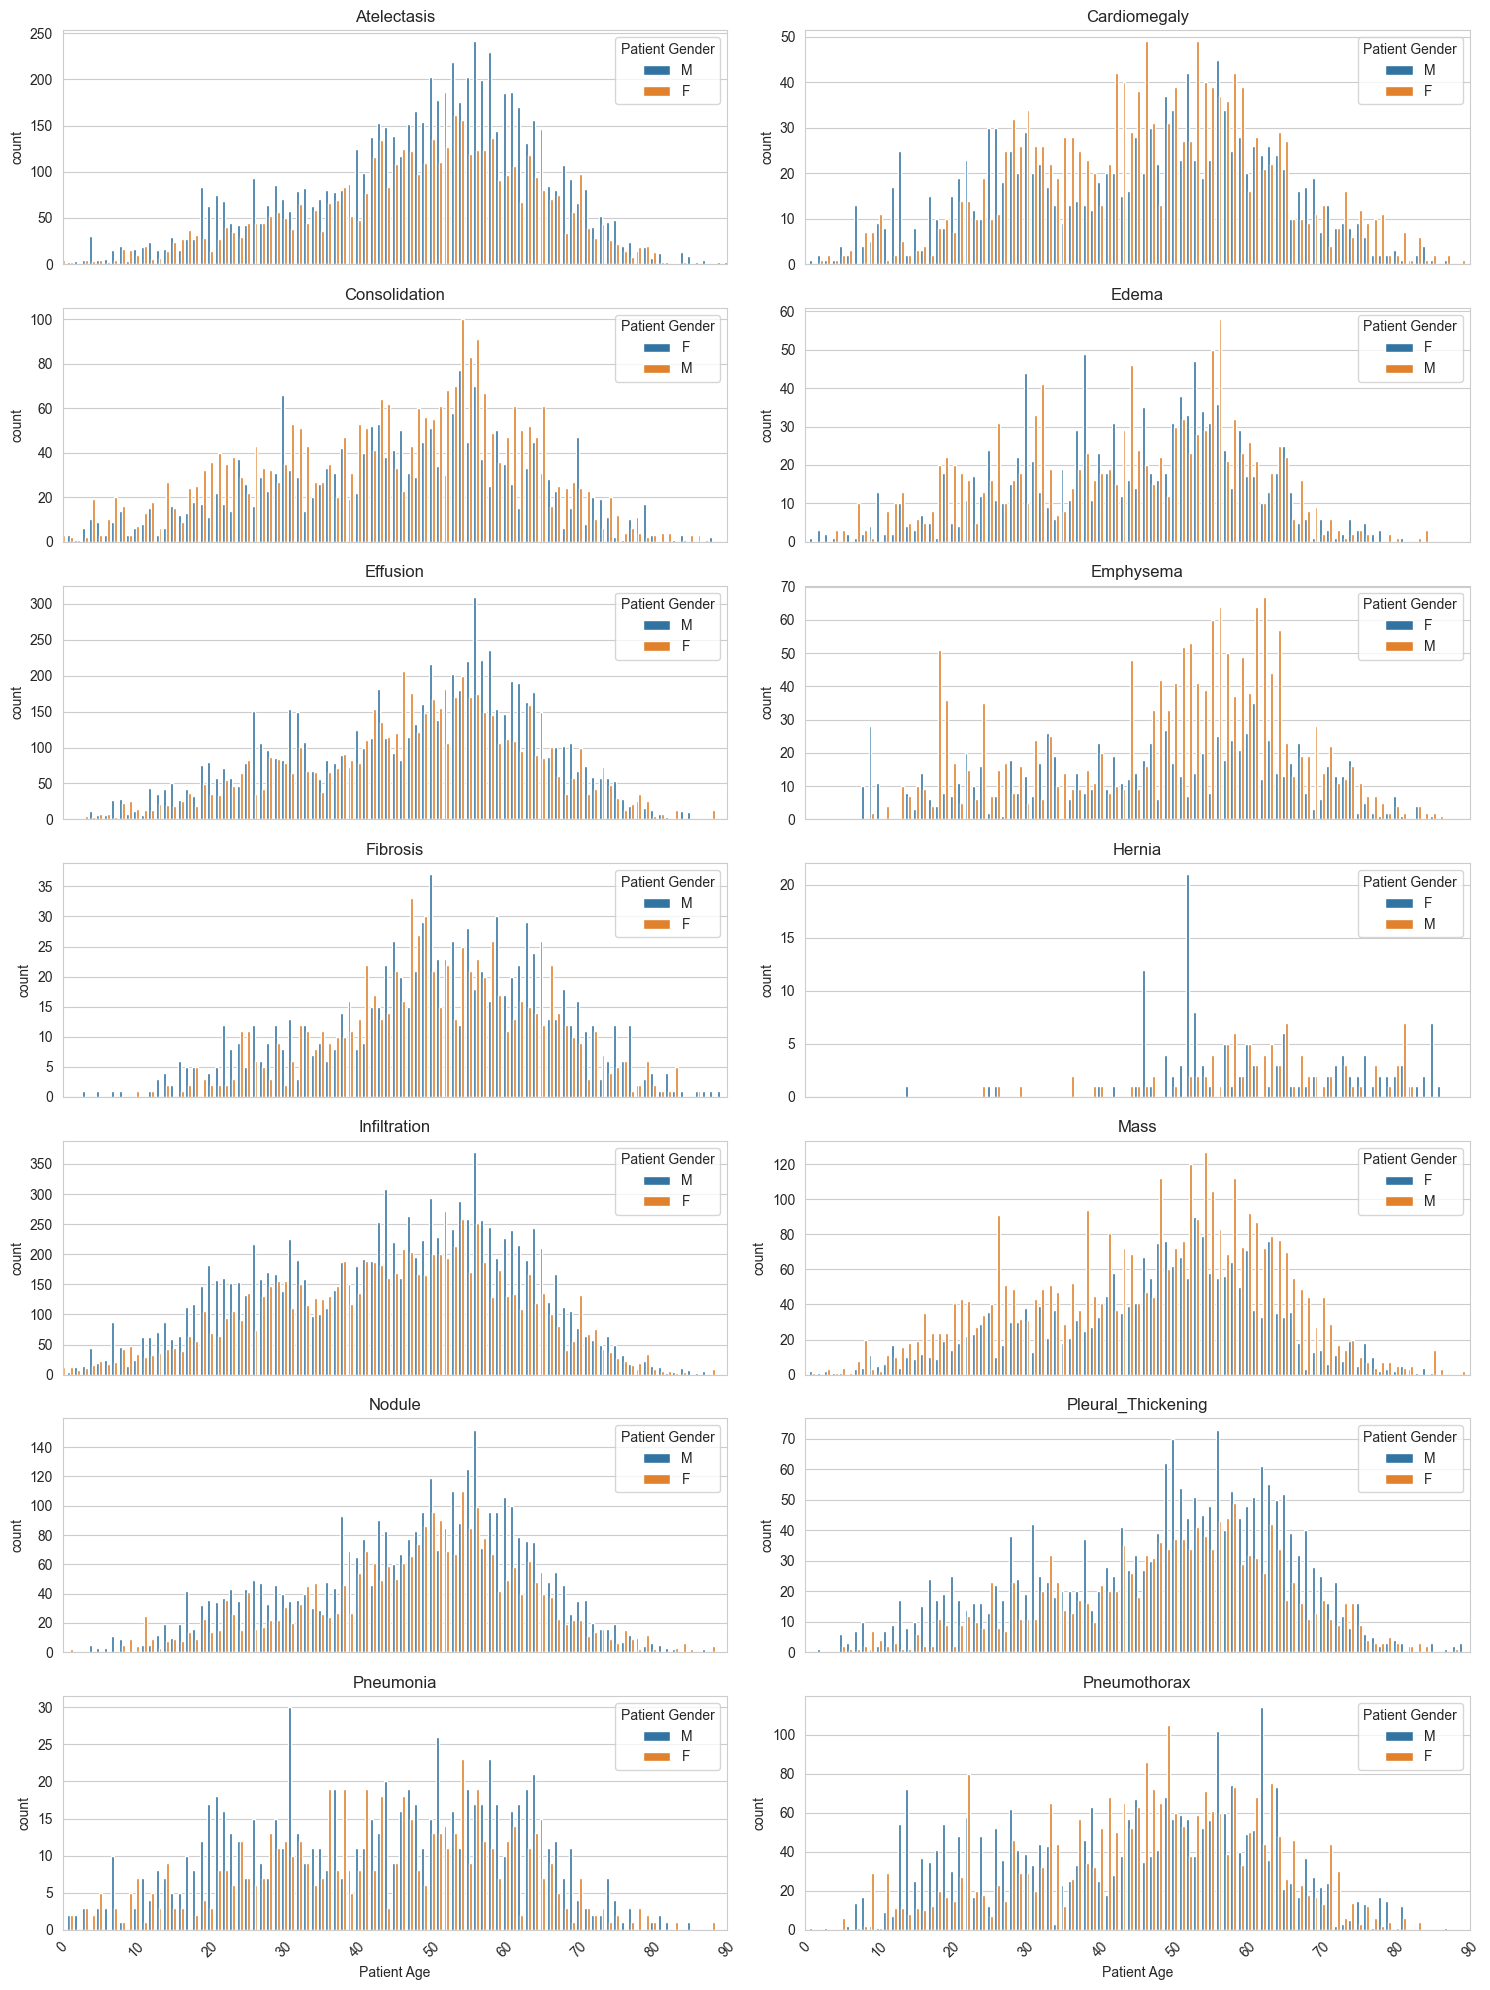

In [18]:
f, axarr = plt.subplots(7, 2, sharex=True, figsize=(15, 20))
pathology_list = [str(item) for item in all_labels]  # Keep the full pathology list
pathology_list1 = [str(item) for item in all_labels if item != "No Finding"]
df = xray_dataset[xray_dataset['Finding Labels'] != 'No Finding']  # Exclude rows where "No Finding" is present
i, j = 0, 0
x = np.arange(0, 100, 10)

for pathology in pathology_list1:
    # Filter rows where the pathology is present in the "Finding Labels"
    index = df['Finding Labels'].apply(lambda x: pathology in x.split('|'))
    filtered_data = df[index]
    
    g = sns.countplot(x='Patient Age', hue="Patient Gender", data=filtered_data, ax=axarr[i, j])
    axarr[i, j].set_title(pathology)
    axarr[i, j].set_xlim(0, 90)
    axarr[i, j].set_xticks(x)
    axarr[i, j].set_xticklabels(x, rotation=45)  # Rotate x-axis labels for better readability
    
    j = (j + 1) % 2
    if j == 0:
        i = (i + 1) % 8

f.subplots_adjust(hspace=0.3)
plt.tight_layout()
plt.show()


### No of each disease by patient gender

In [8]:
for pathology in pathology_list :
    xray_dataset[pathology] = xray_dataset['Finding Labels'].apply(lambda x: 1 if pathology in x else 0)

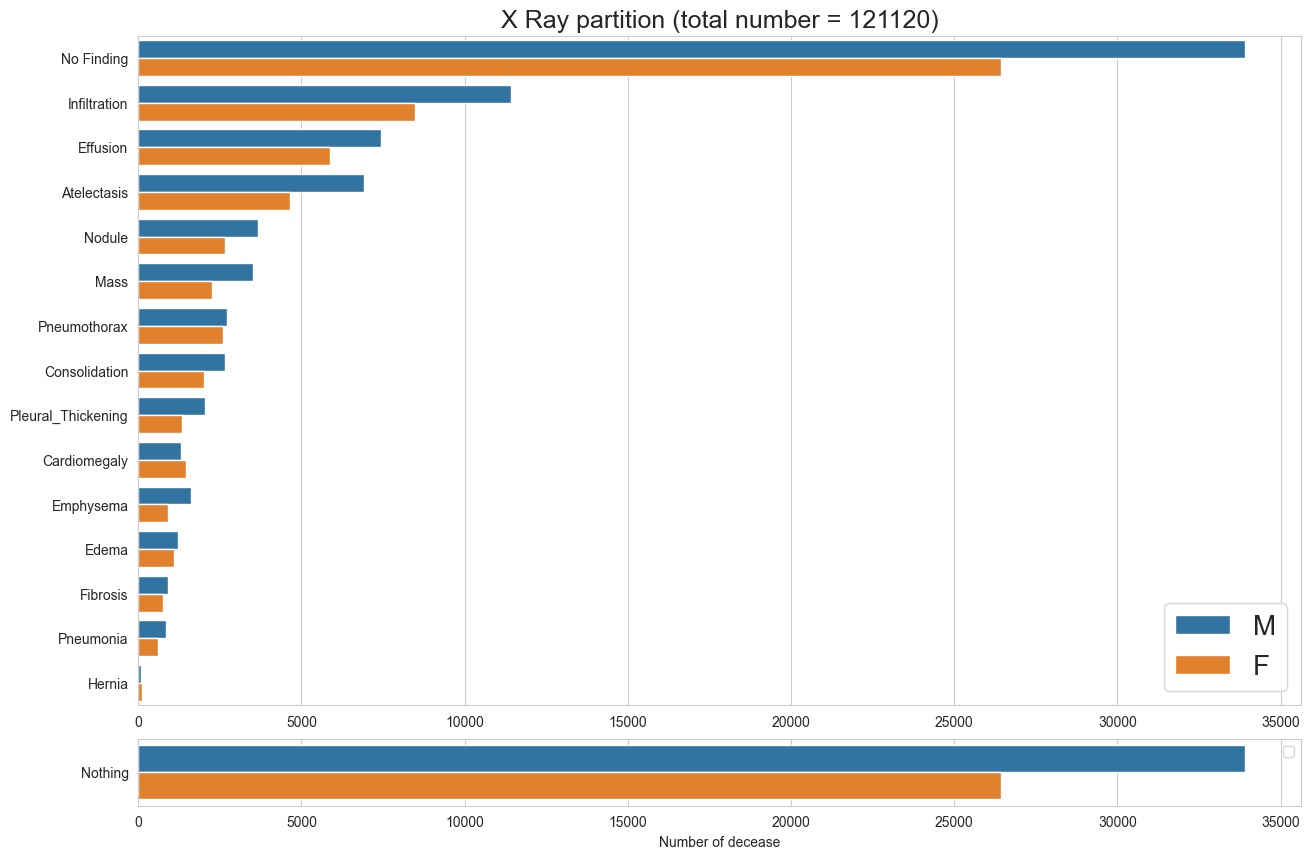

In [9]:
plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(8,1)
ax1 = plt.subplot(gs[:7, :])
ax2 = plt.subplot(gs[7, :])
data1 = pd.melt(xray_dataset,
             id_vars=['Patient Gender'],
             value_vars = list(pathology_list),
             var_name = 'Category',
             value_name = 'Count')
data1 = data1.loc[data1.Count>0]
g=sns.countplot(y='Category',hue='Patient Gender',data=data1, ax=ax1, order = data1['Category'].value_counts().index)
ax1.set( ylabel="",xlabel="")
ax1.legend(fontsize=20)
ax1.set_title('X Ray partition (total number = 121120)',fontsize=18);

xray_dataset['Nothing']=xray_dataset['Finding Labels'].apply(lambda x: 1 if 'No Finding' in x else 0)

data2 = pd.melt(xray_dataset,
             id_vars=['Patient Gender'],
             value_vars = list(['Nothing']),
             var_name = 'Category',
             value_name = 'Count')
data2 = data2.loc[data2.Count>0]
g=sns.countplot(y='Category',hue='Patient Gender',data=data2,ax=ax2)
ax2.set( ylabel="",xlabel="Number of decease")
ax2.legend('')
plt.subplots_adjust(hspace=.5)

### Ratio between one and multiple disease

In [10]:
df=xray_dataset.groupby('Finding Labels').count().sort_values('Patient ID',ascending=False)
df1=df[['|' in index for index in df.index]].copy()
df2=df[['|' not in index for index in df.index]]
df2=df2[['No Finding' not in index for index in df2.index]]
df2['Finding Labels']=df2.index.values
df1['Finding Labels']=df1.index.values

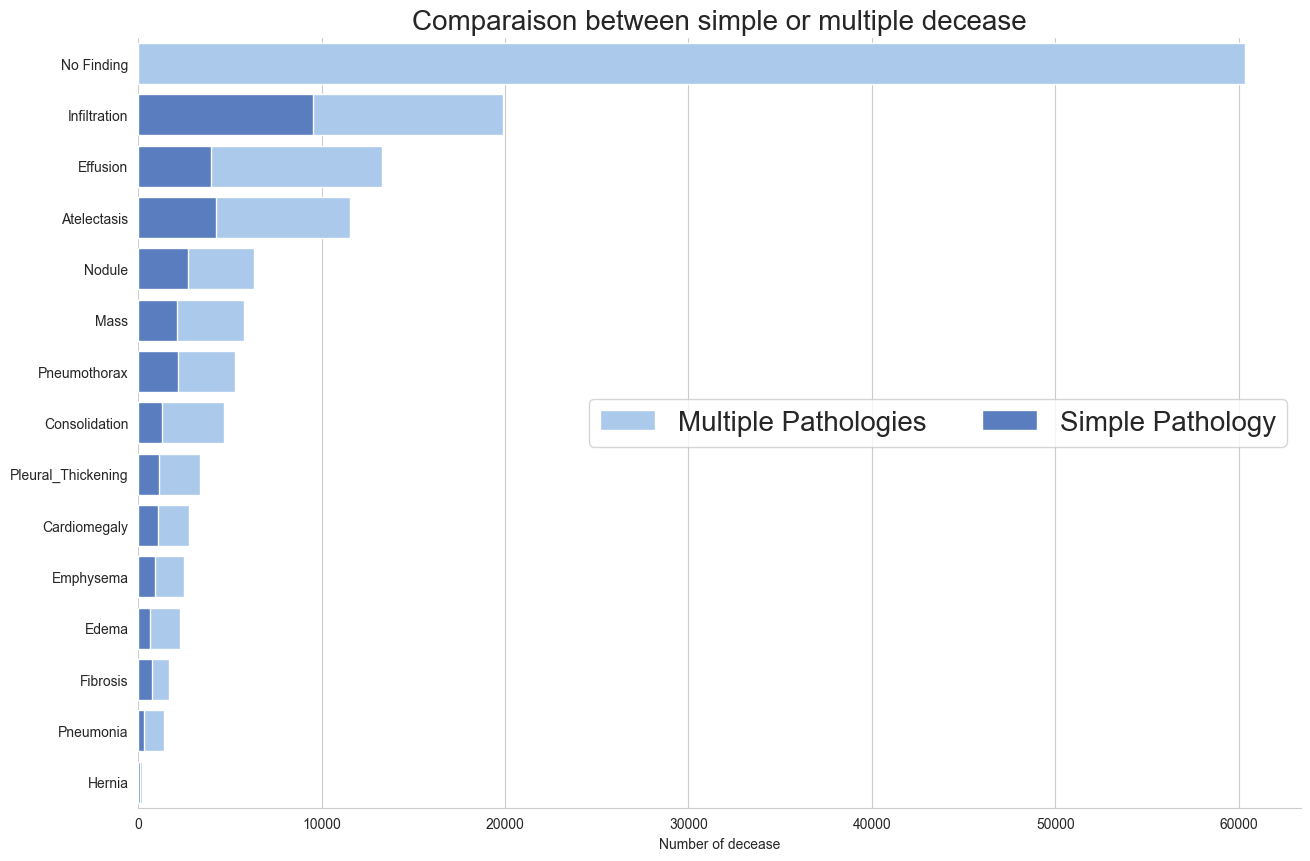

In [11]:
f, ax = plt.subplots(sharex=True,figsize=(15, 10))
sns.set_color_codes("pastel")
g=sns.countplot(y='Category',data=data1, ax=ax, order = data1['Category'].value_counts().index,color='b',label="Multiple Pathologies")
sns.set_color_codes("muted")
g=sns.barplot(x='Patient ID',y='Finding Labels',data=df2, ax=ax, color="b",label="Simple Pathology")
ax.legend(ncol=2, loc="center right", frameon=True,fontsize=20)
ax.set( ylabel="",xlabel="Number of decease")
ax.set_title("Comparaison between simple or multiple decease",fontsize=20)
sns.despine(left=True)

In [12]:
xray_dataset['Finding Labels'] = xray_dataset['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
disease_list = np.unique(list(chain(*xray_dataset['Finding Labels'].map(lambda x: x.split('|')).tolist())))
disease_list = [x for x in disease_list if len(x)>0]


#we just keep groups of pathologies which appear more than 30 times
df3=df1.loc[df1['Patient ID']>30,['Patient ID','Finding Labels']]

for pathology in disease_list:
    df3[pathology]=df3.apply(lambda x: x['Patient ID'] if pathology in x['Finding Labels'] else 0, axis=1)

df3.head(20)

Patient ID  \
Finding Labels                                  
Effusion|Infiltration                    1603   
Atelectasis|Infiltration                 1350   
Atelectasis|Effusion                     1165   
Infiltration|Nodule                       829   
Atelectasis|Effusion|Infiltration         737   
Cardiomegaly|Effusion                     484   
Consolidation|Infiltration                441   
Infiltration|Mass                         420   
Effusion|Pneumothorax                     403   
Effusion|Mass                             402   
Atelectasis|Consolidation                 398   
Mass|Nodule                               394   
Edema|Infiltration                        392   
Infiltration|Pneumothorax                 345   
Consolidation|Effusion                    337   
Emphysema|Pneumothorax                    337   
Effusion|Pleural_Thickening               251   
Effusion|Nodule                           249   
Atelectasis|Pneumothorax                  240   
Infiltration|Pleural_Thickening           210   

                                                      Finding Labels  \
Finding Labels                                                         
Effusion|Infiltration                          Effusion|Infiltration   
Atelectasis|Infiltration                    Atelectasis|Infiltration   
Atelectasis|Effusion                            Atelectasis|Effusion   
Infiltration|Nodule                              Infiltration|Nodule   
Atelectasis|Effusion|Infiltration  Atelectasis|Effusion|Infiltration   
Cardiomegaly|Effusion                          Cardiomegaly|Effusion   
Consolidation|Infiltration                Consolidation|Infiltration   
Infiltration|Mass                                  Infiltration|Mass   
Effusion|Pneumothorax                          Effusion|Pneumothorax   
Effusion|Mass                                          Effusion|Mass   
Atelectasis|Consolidation                  Atelectasis|Consolidation   
Mass|Nodule                                              Mass|Nodule   
Edema|Infiltration                                Edema|Infiltration   
Infiltration|Pneumothorax                  Infiltration|Pneumothorax   
Consolidation|Effusion                        Consolidation|Effusion   
Emphysema|Pneumothorax                        Emphysema|Pneumothorax   
Effusion|Pleural_Thickening              Effusion|Pleural_Thickening   
Effusion|Nodule                                      Effusion|Nodule   
Atelectasis|Pneumothorax                    Atelectasis|Pneumothorax   
Infiltration|Pleural_Thickening      Infiltration|Pleural_Thickening   

                                   Atelectasis  Cardiomegaly  Consolidation  \
Finding Labels                                                                
Effusion|Infiltration                        0             0              0   
Atelectasis|Infiltration                  1350             0              0   
Atelectasis|Effusion                      1165             0              0   
Infiltration|Nodule                          0             0              0   
Atelectasis|Effusion|Infiltration          737             0              0   
Cardiomegaly|Effusion                        0           484              0   
Consolidation|Infiltration                   0             0            441   
Infiltration|Mass                            0             0              0   
Effusion|Pneumothorax                        0             0              0   
Effusion|Mass                                0             0              0   
Atelectasis|Consolidation                  398             0            398   
Mass|Nodule                                  0             0              0   
Edema|Infiltration                           0             0              0   
Infiltration|Pneumothorax                    0             0              0   
Consolidation|Effusion                       0             0            337   
Emphysema|Pneumothorax      

### Co‐Occurrences of Pathologies

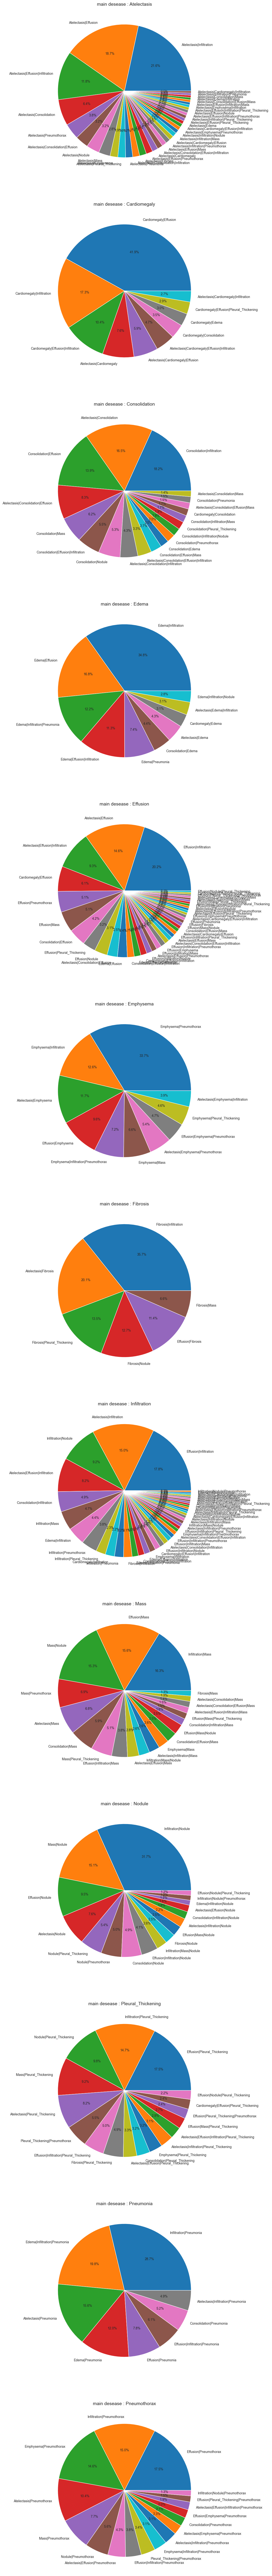

In [13]:
#'Hernia' has not enough values to figure here
df4=df3[df3['Hernia']>0]  # df4.size == 0
#remove 'Hernia' from list
pat_list=[elem for elem in disease_list if 'Hernia' not in elem]

f, axarr = plt.subplots(13, sharex=True,figsize=(10, 140))
i=0
for pathology in pat_list :
    df4=df3[df3[pathology]>0]
    if df4.size>0:  #'Hernia' has not enough values to figure here
        axarr[i].pie(df4[pathology],labels=df4['Finding Labels'], autopct='%1.1f%%')
        axarr[i].set_title('main desease : '+pathology,fontsize=14)
        i +=1

## Preprocessing Labels

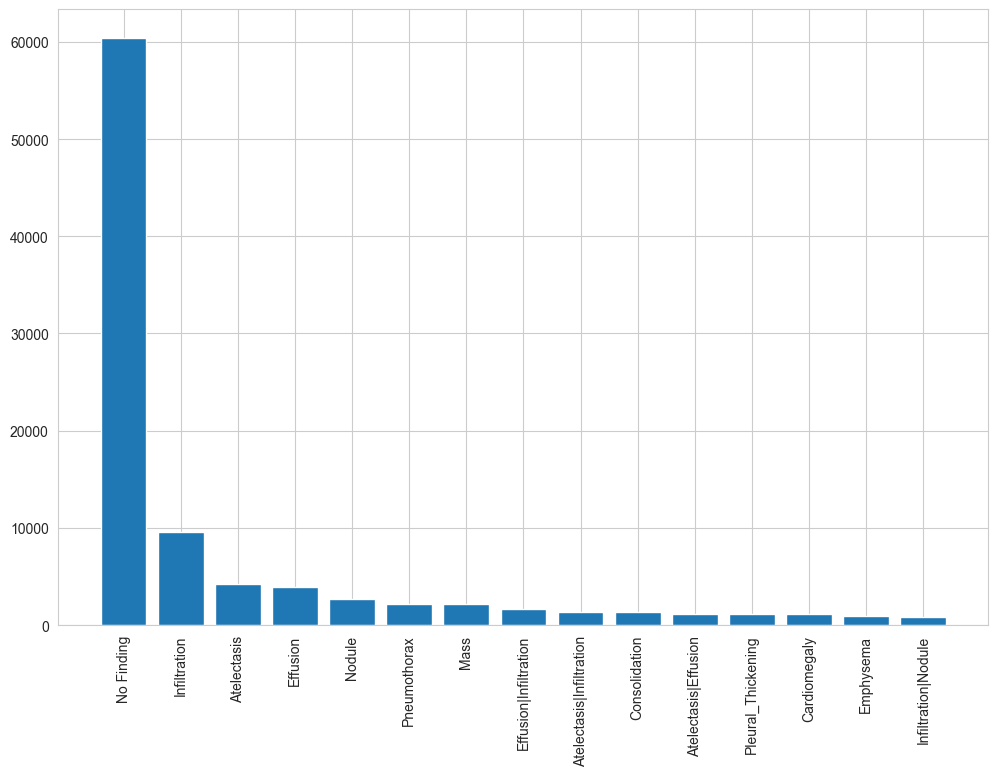

In [5]:
label_counts = xray_dataset['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [6]:
xray_dataset['Finding Labels'] = xray_dataset['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*xray_dataset['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        xray_dataset[c_label] = xray_dataset['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
xray_dataset.sample(3)

All Labels (14): [np.str_('Atelectasis'), np.str_('Cardiomegaly'), np.str_('Consolidation'), np.str_('Edema'), np.str_('Effusion'), np.str_('Emphysema'), np.str_('Fibrosis'), np.str_('Hernia'), np.str_('Infiltration'), np.str_('Mass'), np.str_('Nodule'), np.str_('Pleural_Thickening'), np.str_('Pneumonia'), np.str_('Pneumothorax')]


Image Index        Finding Labels  Follow-up #  Patient ID  \
84703  00020852_019.png                                 19       20852   
68561  00016934_012.png  Atelectasis|Effusion           12       16934   
50146  00012681_046.png           Atelectasis           46       12681   

       Patient Age Patient Gender View Position  Ori_Image_w  Ori_Image_h  \
84703           75              M            AP         3056         2544   
68561           56              M            AP         2500         2048   
50146           60              F            AP         2500         2048   

       Ori_Image_Pixel_Spacing_x  ...  Effusion Emphysema  Fibrosis  Hernia  \
84703                      0.139  ...       0.0       0.0       0.0     0.0   
68561                      0.168  ...       1.0       0.0       0.0     0.0   
50146                      0.168  ...       0.0       0.0       0.0     0.0   

       Infiltration  Mass  Nodule  Pleural_Thickening  Pneumonia  Pneumothorax  
84703           0.0   0.0     0.0                 0.0        0.0           0.0  
68561           0.0   0.0     0.0                 0.0        0.0           0.0  
50146           0.0   0.0     0.0                 0.0        0.0           0.0  

[3 rows x 27 columns]

In [7]:
all_labels

[np.str_('Atelectasis'),
 np.str_('Cardiomegaly'),
 np.str_('Consolidation'),
 np.str_('Edema'),
 np.str_('Effusion'),
 np.str_('Emphysema'),
 np.str_('Fibrosis'),
 np.str_('Hernia'),
 np.str_('Infiltration'),
 np.str_('Mass'),
 np.str_('Nodule'),
 np.str_('Pleural_Thickening'),
 np.str_('Pneumonia'),
 np.str_('Pneumothorax')]

In [8]:
print('Clean Labels ({})'.format(len(all_labels)),
      [(c_label,int(xray_dataset[c_label].sum())) for c_label in all_labels])

Clean Labels (14) [(np.str_('Atelectasis'), 11559), (np.str_('Cardiomegaly'), 2776), (np.str_('Consolidation'), 4667), (np.str_('Edema'), 2303), (np.str_('Effusion'), 13317), (np.str_('Emphysema'), 2516), (np.str_('Fibrosis'), 1686), (np.str_('Hernia'), 227), (np.str_('Infiltration'), 19894), (np.str_('Mass'), 5782), (np.str_('Nodule'), 6331), (np.str_('Pleural_Thickening'), 3385), (np.str_('Pneumonia'), 1431), (np.str_('Pneumothorax'), 5302)]


### Resampling Weight

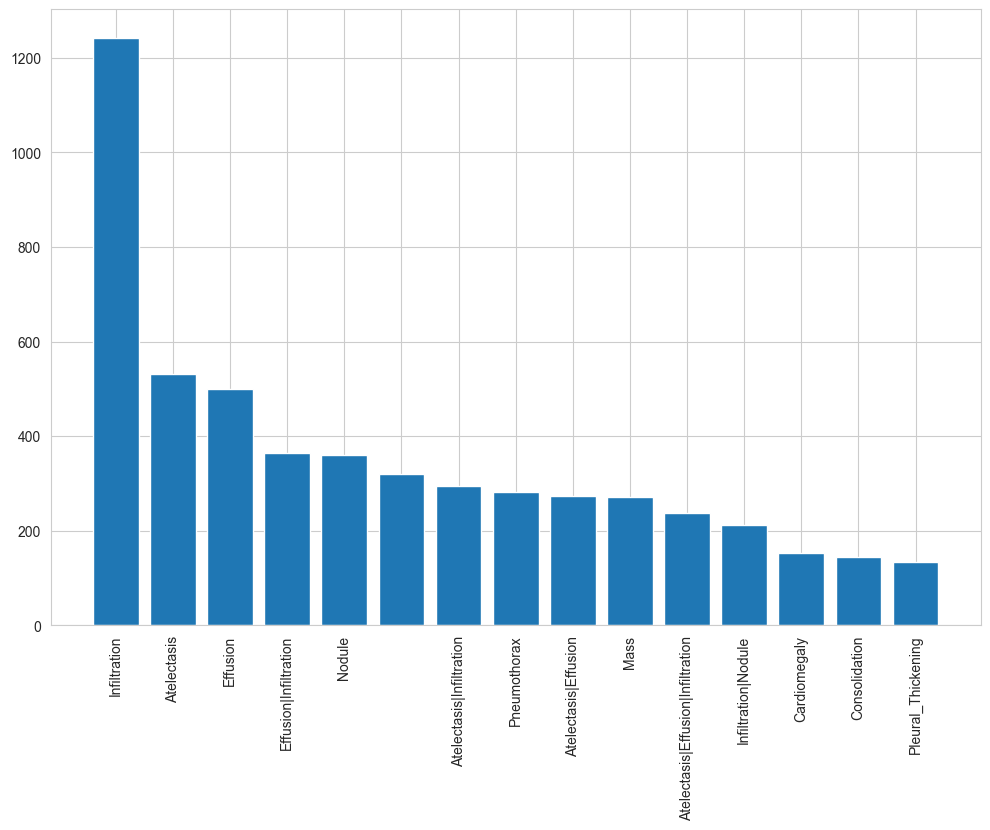

In [9]:
sample_weights = xray_dataset['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
xray_dataset = xray_dataset.sample(10000, weights=sample_weights)

label_counts = xray_dataset['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

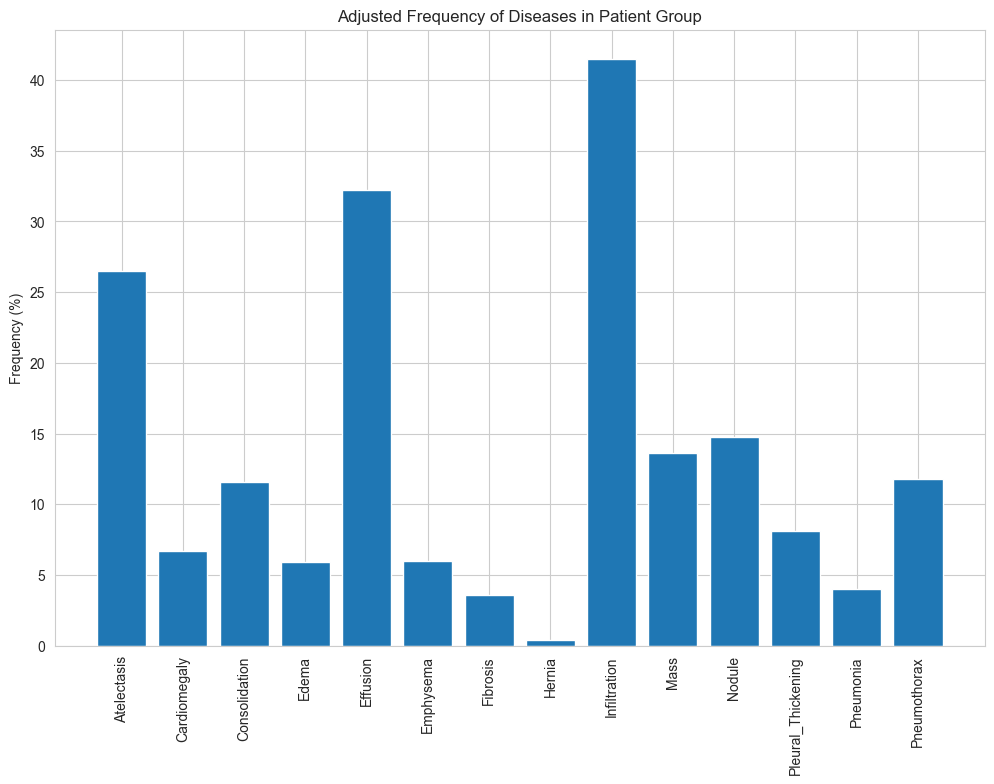

In [10]:
label_counts = 100*np.mean(xray_dataset[all_labels].values,0)
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
ax1.set_xticklabels(all_labels, rotation = 90)
ax1.set_title('Adjusted Frequency of Diseases in Patient Group')
_ = ax1.set_ylabel('Frequency (%)')

## Prepare Training Data

In [11]:
xray_dataset['disease_vec'] = xray_dataset.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])

In [12]:
from sklearn.model_selection import train_test_split


train_df, temp_df = train_test_split(xray_dataset,
                                     test_size=0.25,  
                                     random_state=2018,
                                     stratify = xray_dataset['Finding Labels'].map(lambda x: x[:4]))
test_df, valid_df = train_test_split(temp_df,
                                     test_size=0.25, 
                                     random_state=2018,
                                     stratify = temp_df['Finding Labels'].map(lambda x: x[:4]))


# Print the sizes of the datasets
print(f"Training set size: {train_df.shape[0]}")
# print(f"Validation set size: {valid_df.shape[0]}")
print(f"Testing set size: {valid_df.shape[0]}")
print(f"Testing set size: {test_df.shape[0]}")

Training set size: 7500
Testing set size: 625
Testing set size: 1875


### Create Data Generators

In [13]:
valid_df['newLabel'] = valid_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
train_df['newLabel'] = train_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
test_df['newLabel'] = test_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)

# Data generator for training with augmentation
train_idg = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True,
    horizontal_flip=True,
    vertical_flip=False,
    height_shift_range=0.05,
    width_shift_range=0.1,
    rotation_range=5,
    shear_range=0.1,
    fill_mode='reflect',
    zoom_range=0.15
)

# Data generator for validation and testing without augmentation
core_idg = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True
)



In [15]:

# Training generator with augmentation
train_gen = train_idg.flow_from_dataframe(
    dataframe=train_df,
    directory=None,
    x_col='path',
    y_col=all_labels,
    class_mode='raw',
    target_size=IMG_SIZE,
    color_mode='grayscale',
    batch_size=32
)

# Validation generator without augmentation
valid_gen = core_idg.flow_from_dataframe(
    dataframe=valid_df,
    directory=None,
    x_col='path',
    y_col=all_labels,
    class_mode='raw',
    target_size=IMG_SIZE,
    color_mode='grayscale',
    batch_size=256
)

# Testing generator without augmentation
test_gen = core_idg.flow_from_dataframe(
    dataframe=test_df,
    directory=None,
    x_col='path',
    y_col=all_labels,
    class_mode='raw',
    target_size=IMG_SIZE,
    color_mode='grayscale',
    batch_size=256
)

train_X, train_Y = next(train_idg.flow_from_dataframe(dataframe=train_df,
                             directory=None,
                             x_col = 'path',
                            y_col = all_labels,
                             class_mode = 'raw',
                            # classes = all_labels,
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 1024))

valid_X, valid_Y = next(core_idg.flow_from_dataframe(dataframe=valid_df,
                             directory=None,
                             x_col = 'path',
                            y_col = all_labels,
                             class_mode = 'raw',
                            # classes = all_labels,
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 1024))

test_X, test_Y = next(core_idg.flow_from_dataframe(dataframe=test_df,
                             directory=None,
                             x_col = 'path',
                            y_col = all_labels,
                             class_mode = 'raw',
                            # classes = all_labels,
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 1024))

Found 7500 validated image filenames.
Found 625 validated image filenames.
Found 1875 validated image filenames.
Found 7500 validated image filenames.
Found 625 validated image filenames.
Found 1875 validated image filenames.


In [16]:

# Training generator with augmentation
train_gen_rgb = train_idg.flow_from_dataframe(
    dataframe=train_df,
    directory=None,
    x_col='path',
    y_col=all_labels,
    class_mode='raw',
    target_size=IMG_SIZE,
    color_mode='rgb',
    batch_size=32
)

# Validation generator without augmentation
valid_gen_rgb = core_idg.flow_from_dataframe(
    dataframe=valid_df,
    directory=None,
    x_col='path',
    y_col=all_labels,
    class_mode='raw',
    target_size=IMG_SIZE,
    color_mode='rgb',
    batch_size=256
)

# Testing generator without augmentation
test_gen_rgb = core_idg.flow_from_dataframe(
    dataframe=test_df,
    directory=None,
    x_col='path',
    y_col=all_labels,
    class_mode='raw',
    target_size=IMG_SIZE,
    color_mode='rgb',
    batch_size=256
)

train_X_rgb, train_Y_rgb = next(train_idg.flow_from_dataframe(dataframe=train_df,
                             directory=None,
                             x_col = 'path',
                            y_col = all_labels,
                             class_mode = 'raw',
                            # classes = all_labels,
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 1024))

valid_X_rgb, valid_Y_rgb = next(core_idg.flow_from_dataframe(dataframe=valid_df,
                             directory=None,
                             x_col = 'path',
                            y_col = all_labels,
                             class_mode = 'raw',
                            # classes = all_labels,
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 1024))

test_X_rgb, test_Y_rgb = next(core_idg.flow_from_dataframe(dataframe=test_df,
                             directory=None,
                             x_col = 'path',
                            y_col = all_labels,
                             class_mode = 'raw',
                            # classes = all_labels,
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 1024))

Found 7500 validated image filenames.
Found 625 validated image filenames.
Found 1875 validated image filenames.
Found 7500 validated image filenames.
Found 625 validated image filenames.
Found 1875 validated image filenames.


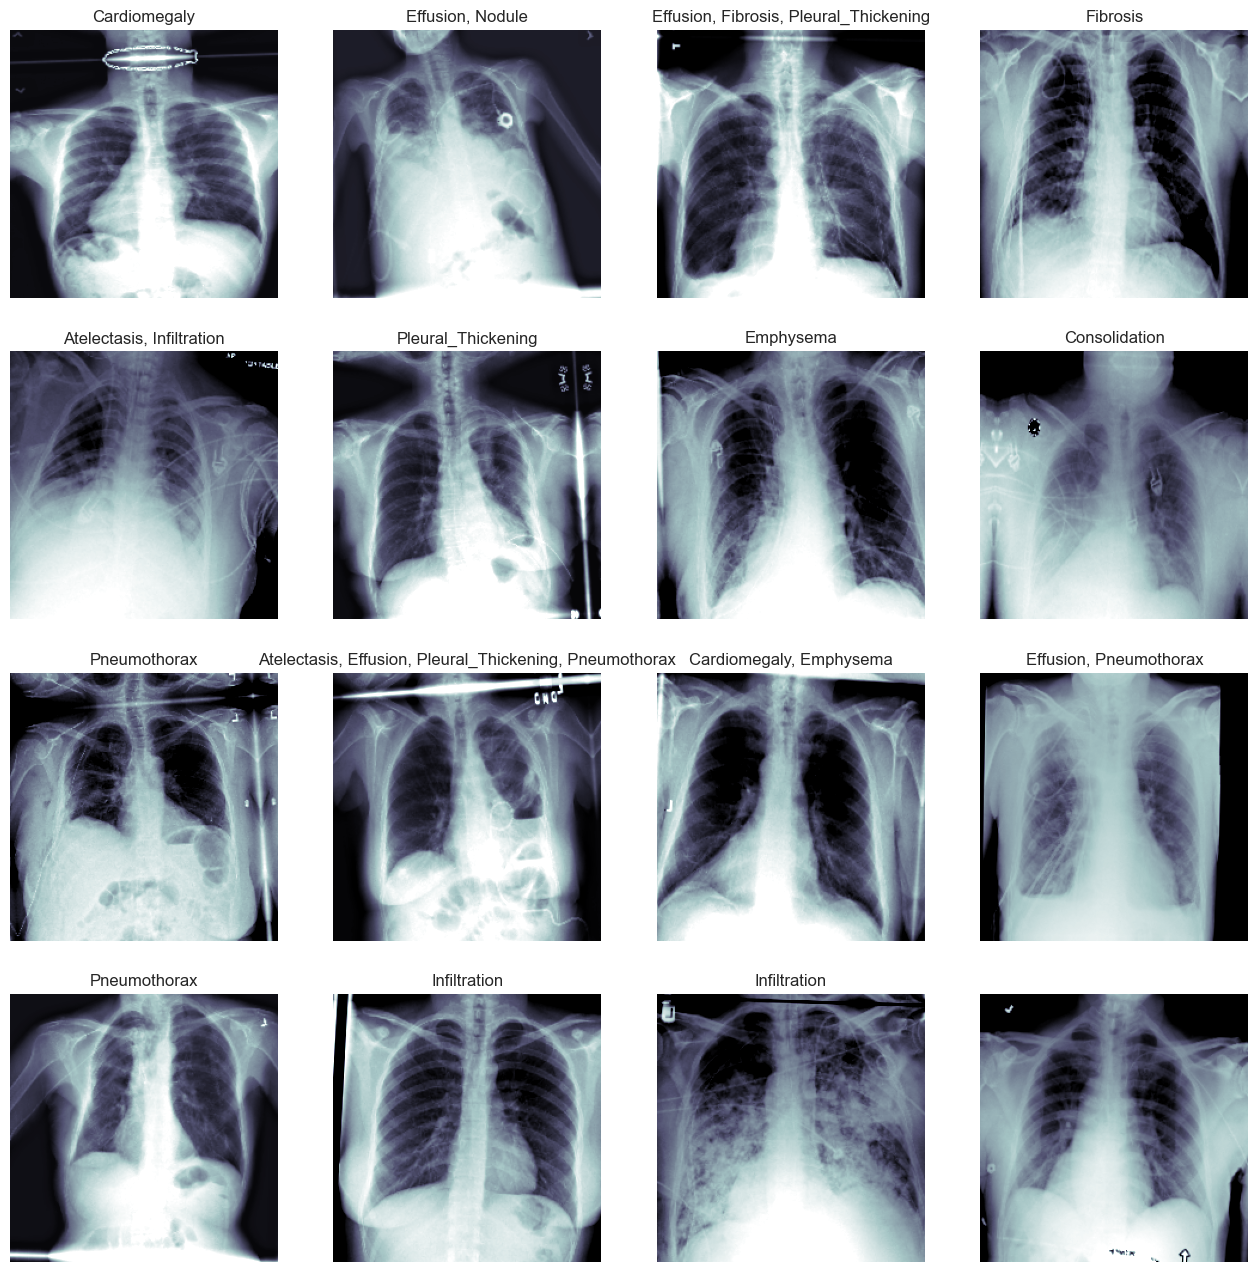

In [17]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y)
                             if n_score>0.5]))
    c_ax.axis('off')

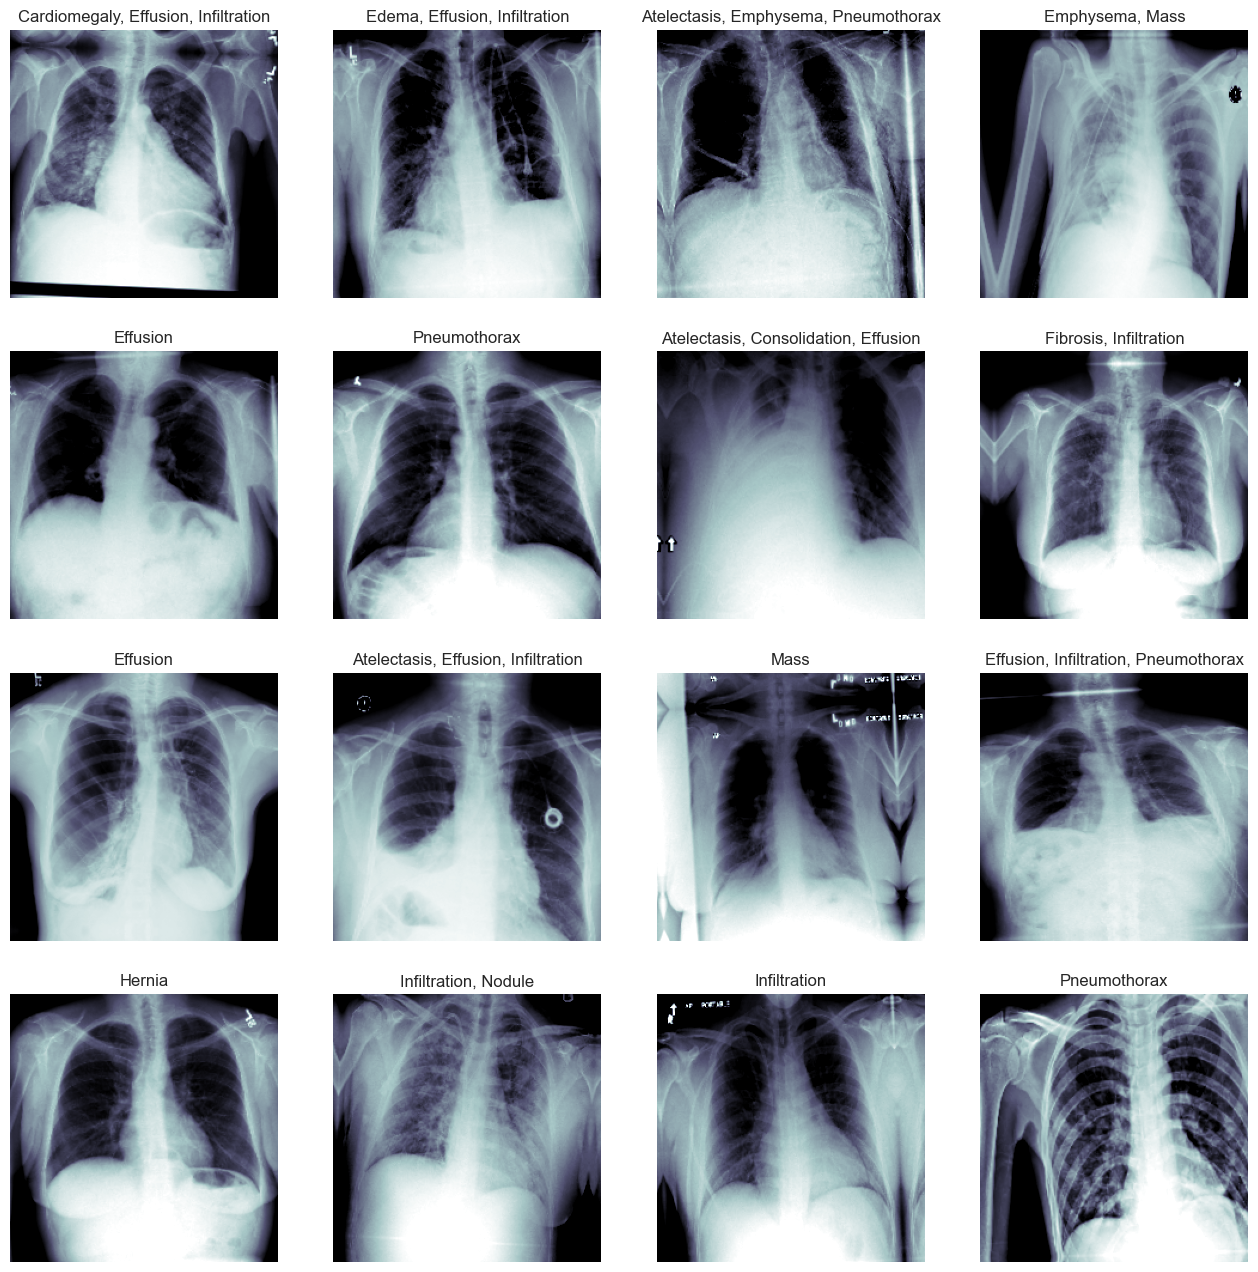

In [18]:
t_x_rgb, t_y_rgb = next(train_gen_rgb)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x_rgb, t_y_rgb, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y)
                             if n_score>0.5]))
    c_ax.axis('off')

# Model Development

## MobileNet Without Weight


In [28]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
from keras import optimizers, callbacks, regularizers
base_mobilenet_model = MobileNet(input_shape =  t_x.shape[1:],
                                 include_top = False, weights = None)
model1 = Sequential()
model1.add(base_mobilenet_model)
model1.add(GlobalAveragePooling2D())
model1.add(Dropout(0.5))
model1.add(Dense(512))
model1.add(Dropout(0.5))
model1.add(Dense(len(all_labels), activation = 'sigmoid'))
model1.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_128 (Functional) │ (None, 4, 4, 1024)     │     3,228,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 14)             │         7,182 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,760,270 (14.34 MB)

 Trainable params: 3,738,382 (14.26 MB)

 Non-trainable params: 21,888 (85.50 KB)

## Optimizer Selection

In [59]:
optimizers_list = [
    ('sgd', optimizers.SGD(learning_rate=0.1)),
    ('sgd_momentum', optimizers.SGD(learning_rate=0.1, momentum=0.9)),
    ('adagrad', optimizers.Adagrad()),
    ('adadelta', optimizers.Adadelta()),
    ('adam', optimizers.Adam())
]

# early = EarlyStopping(monitor="val_loss",
#                       mode="min",
#                       patience=5)

# callbacks_list = [early, ModelCheckpoint( filepath=weight_path, monitor='val_loss', mode='min', save_best_only=True )]

In [29]:
validation_steps = len(valid_df) // 256
if len(valid_df) % 256 != 0:
    validation_steps += 1  # Ensure covering all samples

In [30]:
print(validation_steps)

24


Training with optimizer: sgd
Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.8310 - loss: 0.4350 - mae: 0.2292
Epoch 1: val_loss improved from inf to 0.49516, saving model to model1_weights.best.weights.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - binary_accuracy: 0.8312 - loss: 0.4347 - mae: 0.2290 - val_binary_accuracy: 0.8795 - val_loss: 0.4952 - val_mae: 0.3791
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.8589 - loss: 0.3845 - mae: 0.2000
Epoch 2: val_loss improved from 0.49516 to 0.38932, saving model to model1_weights.best.weights.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - binary_accuracy: 0.8589 - loss: 0.3844 - mae: 0.1999 - val_binary_accuracy: 0.8795 - val_loss: 0.3893 - val_mae: 0.2872
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.8652 - loss: 0.3701 - mae: 0.1945
Epoch 3: val_loss improved from 0.38932 to 0.35286, saving model to model1_weights.best.weights.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 132

c:\Users\keat.siewwk\AppData\Local\anaconda3\envs\myenv\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 9: val_loss improved from 0.32470 to 0.32198, saving model to model1_weights.best.weights.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - binary_accuracy: 0.8744 - loss: 0.3417 - mae: 0.1917 - val_binary_accuracy: 0.8791 - val_loss: 0.3220 - val_mae: 0.1819
Epoch 10/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.8725 - loss: 0.3484 - mae: 0.1953
Epoch 10: val_loss did not improve from 0.32198
100/100 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - binary_accuracy: 0.8725 - loss: 0.3484 - mae: 0.1953 - val_binary_accuracy: 0.8753 - val_loss: 0.3269 - val_mae: 0.1823
Epoch 11/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.8695 - loss: 0.3484 - mae: 0.1971
Epoch 11: val_loss did not improve from 0.32198
100/100 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - binary_accuracy: 0.8695 - loss: 0.3484 - mae: 0.1971 - val_binary_accuracy: 0.8782 - val_loss: 0.3293 - val_mae: 0.1730
Epoch 12/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.8763 - loss: 0.3361 - mae

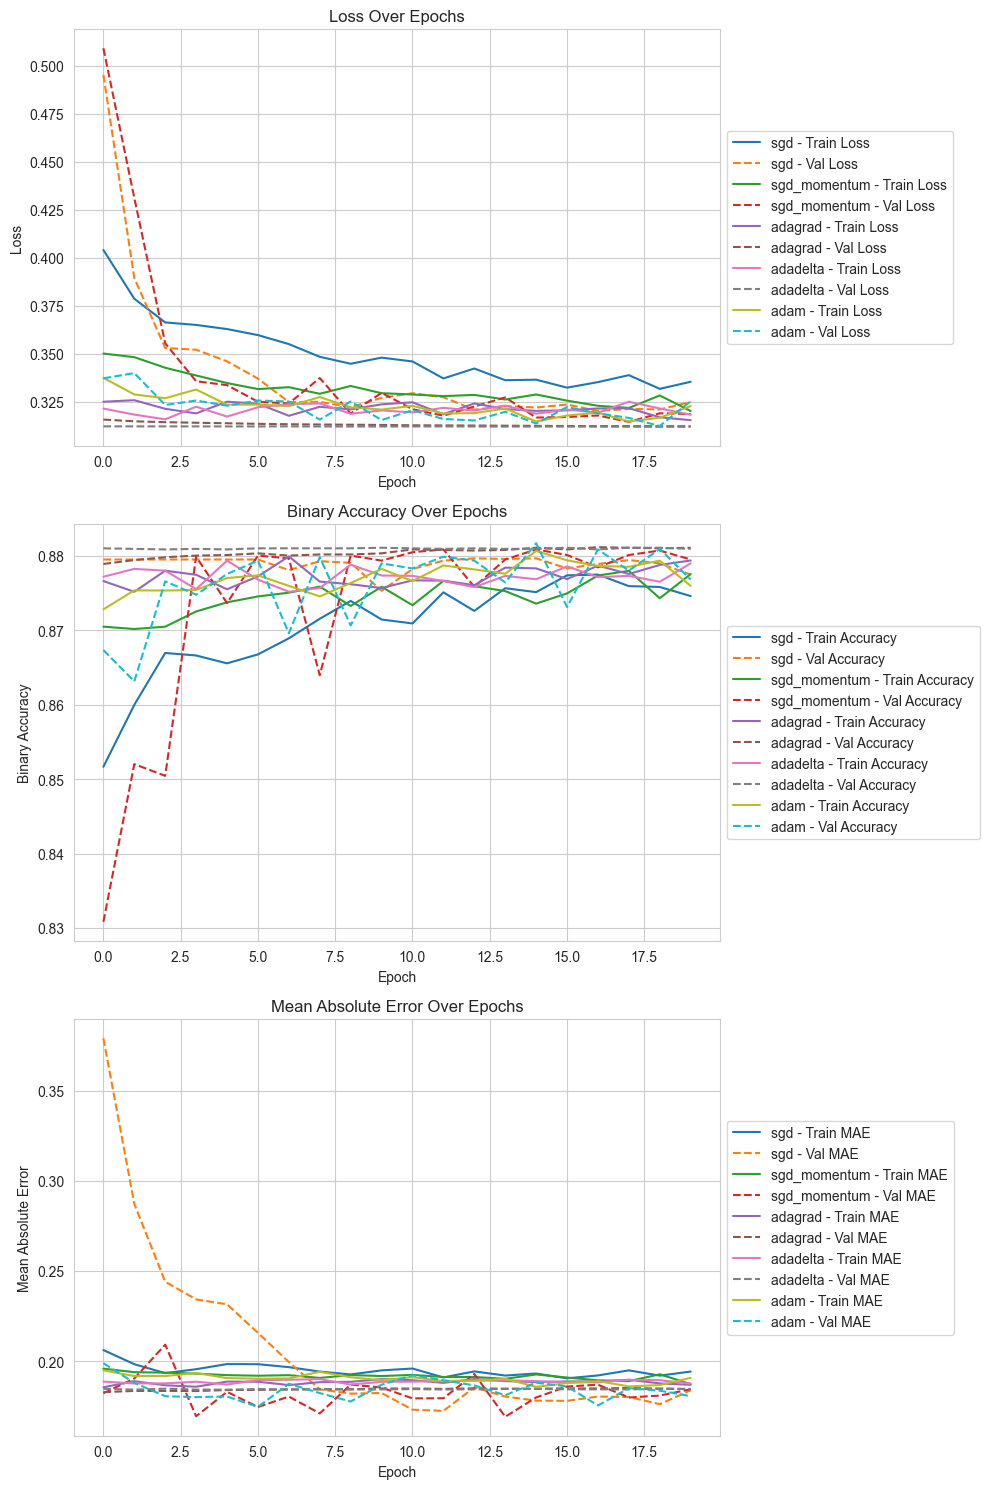

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path = "{}_weights.best.weights.h5".format('model1a')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=5)
callbacks_list = [checkpoint, early]


# Dictionary to store metrics for each optimizer
optimizer_results = {}

# Assuming model1, train_gen, test_X, test_Y, and callbacks_list are defined
for optimizer in optimizers_list:
    print(f"Training with optimizer: {optimizer[0]}")
    model1.compile(optimizer=optimizer[1], loss='binary_crossentropy',
                                metrics=['binary_accuracy', 'mae'])

    history = model1.fit(train_gen,
                                      steps_per_epoch=100,
                                      validation_data=(valid_X, valid_Y),
                                      validation_steps=validation_steps,
                                      epochs=20,
                                      callbacks=callbacks_list)
    print("Available history keys:", history.history.keys())  # Debug statement
    # Store the history
    predictions = model1.predict(test_X, batch_size=32, verbose=True)
    optimizer_results[optimizer[0]] = {
        'history': history.history,
        'predictions': predictions
    }

    print(f"{optimizer[0]} training completed.")

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# Plot 1: Loss
for optimizer_name, optimizer_data in optimizer_results.items():
    history = optimizer_data['history']
    if 'loss' in history and 'val_loss' in history:
        axes[0].plot(history['loss'], label=f"{optimizer_name} - Train Loss")
        axes[0].plot(history['val_loss'], linestyle="--", label=f"{optimizer_name} - Val Loss")
    else:
        print(f"Loss data not found for optimizer: {optimizer_name}")

axes[0].set_title("Loss Over Epochs")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes[0].grid(True)

# Plot 2: Binary Accuracy
for optimizer_name, optimizer_data in optimizer_results.items():
    history = optimizer_data['history']
    if 'binary_accuracy' in history and 'val_binary_accuracy' in history:
        axes[1].plot(history['binary_accuracy'], label=f"{optimizer_name} - Train Accuracy")
        axes[1].plot(history['val_binary_accuracy'], linestyle="--", label=f"{optimizer_name} - Val Accuracy")
    else:
        print(f"Binary accuracy data not found for optimizer: {optimizer_name}")

axes[1].set_title("Binary Accuracy Over Epochs")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Binary Accuracy")
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes[1].grid(True)

# Plot 3: Mean Absolute Error
for optimizer_name, optimizer_data in optimizer_results.items():
    history = optimizer_data['history']
    if 'mae' in history and 'val_mae' in history:
        axes[2].plot(history['mae'], label=f"{optimizer_name} - Train MAE")
        axes[2].plot(history['val_mae'], linestyle="--", label=f"{optimizer_name} - Val MAE")
    else:
        print(f"MAE data not found for optimizer: {optimizer_name}")

axes[2].set_title("Mean Absolute Error Over Epochs")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Mean Absolute Error")
axes[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes[2].grid(True)

plt.tight_layout()
plt.show()

## Fully Custom

In [40]:
from keras.layers import Input, Conv2D, DepthwiseConv2D, BatchNormalization, ReLU, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, Add, SeparableConv2D
from keras.models import Model
from keras import optimizers, callbacks, regularizers
# Model input
input_layer = Input(shape=t_x.shape[1:])

# First block
x = Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(input_layer)
x = MaxPooling2D(pool_size=2)(x)
x = Dropout(0.1)(x)

# Second block
x = Conv2D(filters=96, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Dropout(0.1)(x)

# Third block
x = Conv2D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Dropout(0.1)(x)

# Fourth block
x = Conv2D(filters=160, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Dropout(0.1)(x)

# Fifth block
x = Conv2D(filters=192, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Dropout(0.1)(x)

# Sixth block
x = Conv2D(filters=224, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Dropout(0.1)(x)

# Seventh block
x = Conv2D(filters=256, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Dropout(0.1)(x)

# Pooling and output
x = GlobalAveragePooling2D()(x)
output = Dense(units=14, activation='sigmoid')(x)

# Define the Model
model2 = Model(inputs=input_layer, outputs=output)

# Compile the model
model2.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['binary_accuracy', 'mae'])

# Summary of the model
model2.summary()


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 128, 128, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 32, 32, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 32, 32, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 128)    │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 16, 16, 160)    │       184,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 8, 8, 160)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 8, 8, 160)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 192)      │       276,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 4, 4, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 4, 4, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 4, 4, 224)      │       387,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 2, 2, 224)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 2, 2, 224)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 2, 2, 256)      │       516,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 14)             │         3,598 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 1,535,150 (5.86 MB)

 Trainable params: 1,535,150 (5.86 MB)

 Non-trainable params: 0 (0.00 B)

Training with optimizer: sgd
Epoch 1/20


c:\Users\keat.siewwk\AppData\Local\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 842ms/step - binary_accuracy: 0.8116 - loss: 0.4454 - mae: 0.2962
Epoch 1: val_loss improved from inf to 0.35762, saving model to model2_weights.best.weights.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 90s 897ms/step - binary_accuracy: 0.8121 - loss: 0.4446 - mae: 0.2955 - val_binary_accuracy: 0.8796 - val_loss: 0.3576 - val_mae: 0.2556
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 845ms/step - binary_accuracy: 0.8743 - loss: 0.3397 - mae: 0.2018
Epoch 2: val_loss did not improve from 0.35762
100/100 ━━━━━━━━━━━━━━━━━━━━ 89s 898ms/step - binary_accuracy: 0.8743 - loss: 0.3397 - mae: 0.2018 - val_binary_accuracy: 0.8795 - val_loss: 0.3649 - val_mae: 0.2653
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 824ms/step - binary_accuracy: 0.8731 - loss: 0.3394 - mae: 0.2012
Epoch 3: val_loss did not improve from 0.35762
100/100 ━━━━━━━━━━━━━━━━━━━━ 93s 928ms/step - binary_accuracy: 0.8731 - loss: 0.3394 - mae: 0.2012 - val_binary_accuracy: 0.8795 - val_loss: 0.3665 - val_mae: 0.26

c:\Users\keat.siewwk\AppData\Local\anaconda3\envs\myenv\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 9: val_loss did not improve from 0.34934
100/100 ━━━━━━━━━━━━━━━━━━━━ 63s 626ms/step - binary_accuracy: 0.8781 - loss: 0.3285 - mae: 0.1941 - val_binary_accuracy: 0.8795 - val_loss: 0.3542 - val_mae: 0.2534
Epoch 10/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 783ms/step - binary_accuracy: 0.8781 - loss: 0.3296 - mae: 0.1946
Epoch 10: val_loss did not improve from 0.34934
100/100 ━━━━━━━━━━━━━━━━━━━━ 84s 834ms/step - binary_accuracy: 0.8781 - loss: 0.3296 - mae: 0.1947 - val_binary_accuracy: 0.8785 - val_loss: 0.3687 - val_mae: 0.2703
Epoch 11/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 773ms/step - binary_accuracy: 0.8756 - loss: 0.3305 - mae: 0.1967
Epoch 11: val_loss improved from 0.34934 to 0.34719, saving model to model2_weights.best.weights.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 827ms/step - binary_accuracy: 0.8756 - loss: 0.3305 - mae: 0.1967 - val_binary_accuracy: 0.8795 - val_loss: 0.3472 - val_mae: 0.2441
Epoch 12/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 754ms/step - binary_accuracy: 0.8746 - los

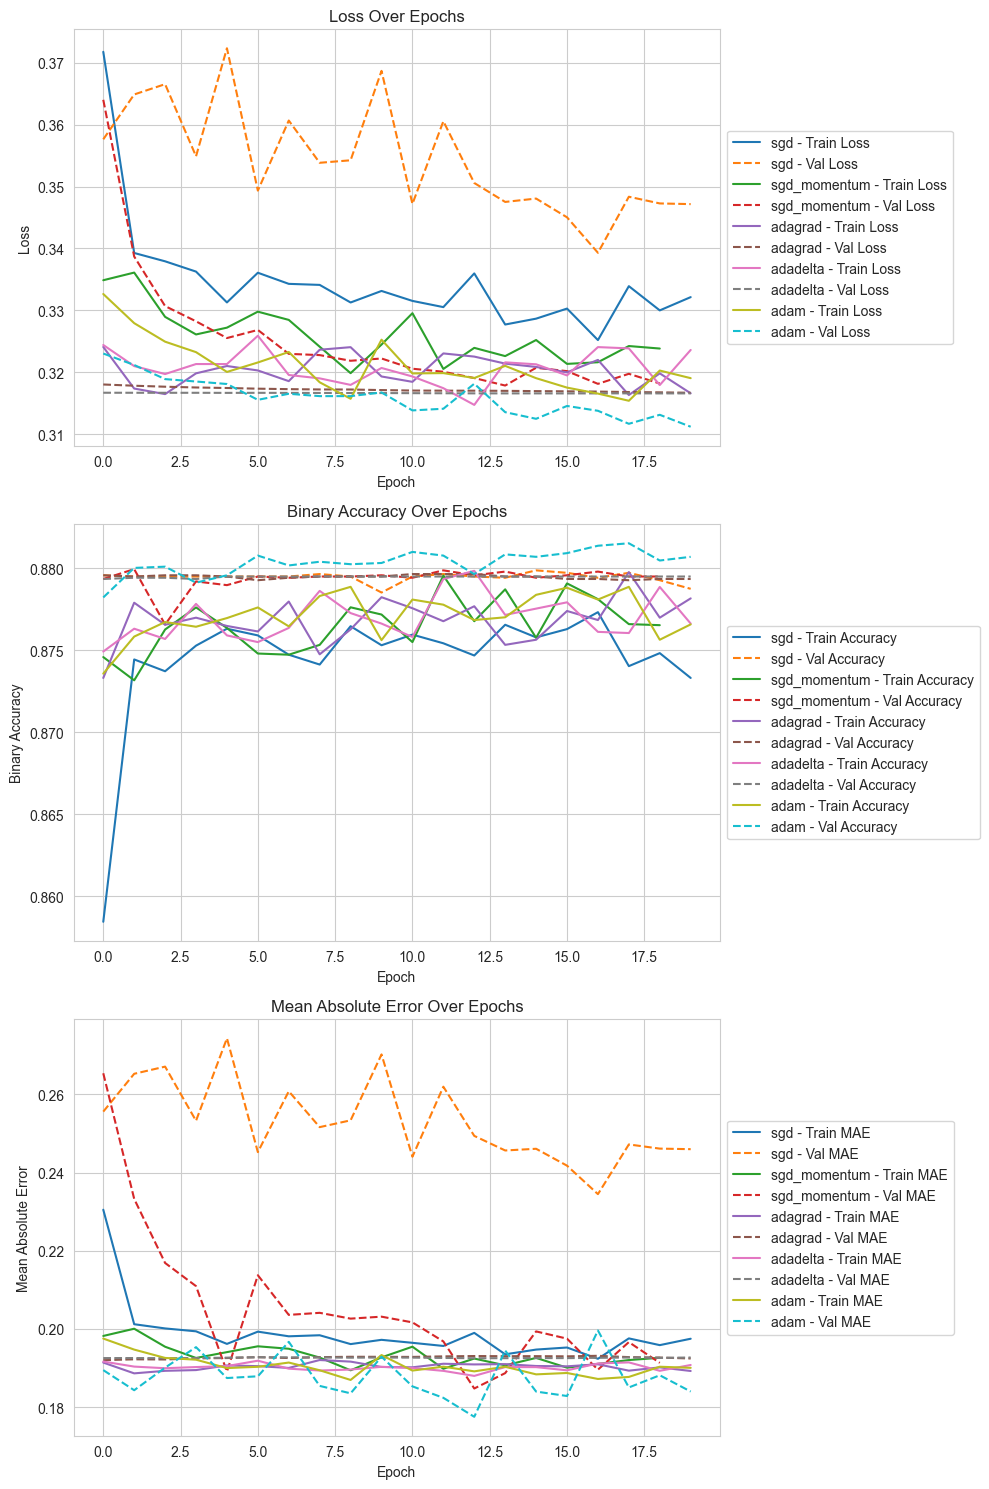

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
optimizers_list = [
    ('sgd', optimizers.SGD(learning_rate=0.1)),
    ('sgd_momentum', optimizers.SGD(learning_rate=0.1, momentum=0.9)),
    ('adagrad', optimizers.Adagrad()),
    ('adadelta', optimizers.Adadelta()),
    ('adam', optimizers.Adam())
]

weight_path = "{}_weights.best.weights.h5".format('model2')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=5)
callbacks_list = [checkpoint, early]


# Dictionary to store metrics for each optimizer
optimizer_results = {}

# Assuming model1, train_gen, test_X, test_Y, and callbacks_list are defined
for optimizer in optimizers_list:
    print(f"Training with optimizer: {optimizer[0]}")
    model2.compile(optimizer=optimizer[1], loss='binary_crossentropy',
                                metrics=['binary_accuracy', 'mae'])

    history = model2.fit(train_gen,
                                      steps_per_epoch=100,
                                      validation_data=(valid_X, valid_Y),
                                      validation_steps=validation_steps,
                                      epochs=20,
                                      callbacks=callbacks_list)
    print("Available history keys:", history.history.keys())  # Debug statement
    # Store the history
    predictions = model2.predict(test_X, batch_size=32, verbose=True)
    optimizer_results[optimizer[0]] = {
        'history': history.history,
        'predictions': predictions
    }

    print(f"{optimizer[0]} training completed.")

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# Plot 1: Loss
for optimizer_name, optimizer_data in optimizer_results.items():
    history = optimizer_data['history']
    if 'loss' in history and 'val_loss' in history:
        axes[0].plot(history['loss'], label=f"{optimizer_name} - Train Loss")
        axes[0].plot(history['val_loss'], linestyle="--", label=f"{optimizer_name} - Val Loss")
    else:
        print(f"Loss data not found for optimizer: {optimizer_name}")

axes[0].set_title("Loss Over Epochs")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes[0].grid(True)

# Plot 2: Binary Accuracy
for optimizer_name, optimizer_data in optimizer_results.items():
    history = optimizer_data['history']
    if 'binary_accuracy' in history and 'val_binary_accuracy' in history:
        axes[1].plot(history['binary_accuracy'], label=f"{optimizer_name} - Train Accuracy")
        axes[1].plot(history['val_binary_accuracy'], linestyle="--", label=f"{optimizer_name} - Val Accuracy")
    else:
        print(f"Binary accuracy data not found for optimizer: {optimizer_name}")

axes[1].set_title("Binary Accuracy Over Epochs")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Binary Accuracy")
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes[1].grid(True)

# Plot 3: Mean Absolute Error
for optimizer_name, optimizer_data in optimizer_results.items():
    history = optimizer_data['history']
    if 'mae' in history and 'val_mae' in history:
        axes[2].plot(history['mae'], label=f"{optimizer_name} - Train MAE")
        axes[2].plot(history['val_mae'], linestyle="--", label=f"{optimizer_name} - Val MAE")
    else:
        print(f"MAE data not found for optimizer: {optimizer_name}")

axes[2].set_title("Mean Absolute Error Over Epochs")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Mean Absolute Error")
axes[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes[2].grid(True)

plt.tight_layout()
plt.show()

# Train Model

## MobileNet Without Weight

Training with optimizer: adam
Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - binary_accuracy: 0.8839 - loss: 0.3181 - mae: 0.1812
Epoch 1: val_loss improved from inf to 0.32807, saving model to model1_weights.best.weights.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - binary_accuracy: 0.8839 - loss: 0.3181 - mae: 0.1812 - val_binary_accuracy: 0.8734 - val_loss: 0.3281 - val_mae: 0.1682
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - binary_accuracy: 0.8868 - loss: 0.3123 - mae: 0.1796
Epoch 2: val_loss improved from 0.32807 to 0.32431, saving model to model1_weights.best.weights.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - binary_accuracy: 0.8868 - loss: 0.3123 - mae: 0.1797 - val_binary_accuracy: 0.8845 - val_loss: 0.3243 - val_mae: 0.1643
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 729ms/step - binary_accuracy: 0.8832 - loss: 0.3153 - mae: 0.1833
Epoch 3: val_loss improved from 0.32431 to 0.31713, saving model to model1_weights.best.weights.h5
100/100 ━━━━━━━━━━━━━━

c:\Users\keat.siewwk\AppData\Local\anaconda3\envs\myenv\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 9: val_loss did not improve from 0.30381
100/100 ━━━━━━━━━━━━━━━━━━━━ 86s 866ms/step - binary_accuracy: 0.8848 - loss: 0.3056 - mae: 0.1814 - val_binary_accuracy: 0.8868 - val_loss: 0.3048 - val_mae: 0.1587
Epoch 10/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 931ms/step - binary_accuracy: 0.8846 - loss: 0.3068 - mae: 0.1803
Epoch 10: val_loss improved from 0.30381 to 0.30167, saving model to model1_weights.best.weights.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - binary_accuracy: 0.8846 - loss: 0.3068 - mae: 0.1803 - val_binary_accuracy: 0.8864 - val_loss: 0.3017 - val_mae: 0.1666
Epoch 11/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 921ms/step - binary_accuracy: 0.8856 - loss: 0.3043 - mae: 0.1796
Epoch 11: val_loss improved from 0.30167 to 0.29933, saving model to model1_weights.best.weights.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - binary_accuracy: 0.8855 - loss: 0.3043 - mae: 0.1796 - val_binary_accuracy: 0.8860 - val_loss: 0.2993 - val_mae: 0.1718
Epoch 12/20
100/100 ━━━━━━━━━━━━━━━━━━

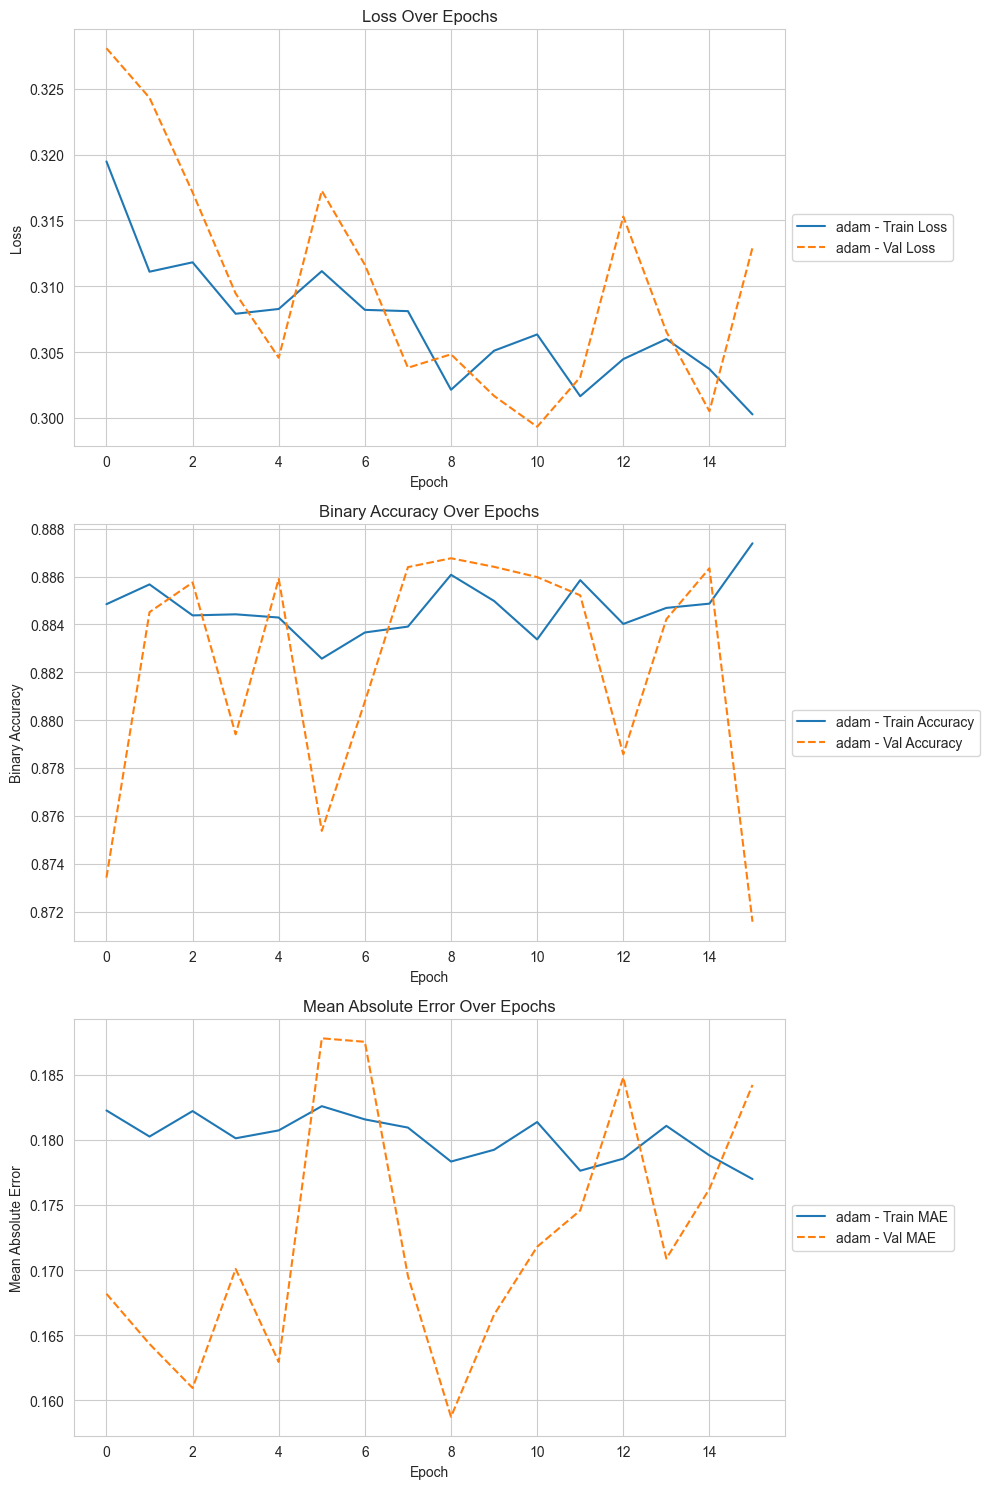

In [47]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

optimizers_list = [
    # ('sgd', optimizers.SGD(learning_rate=0.1)),
    # ('sgd_momentum', optimizers.SGD(learning_rate=0.1, momentum=0.9)),
    # ('adagrad', optimizers.Adagrad()),
    # ('adadelta', optimizers.Adadelta()),
    ('adam', optimizers.Adam())
]


weight_path = "{}_weights.best.weights.h5".format('model1')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=5)
callbacks_list = [checkpoint, early]


# Dictionary to store metrics for each optimizer
optimizer_results = {}

# Assuming model1, train_gen, test_X, test_Y, and callbacks_list are defined
for optimizer in optimizers_list:
    print(f"Training with optimizer: {optimizer[0]}")
    model1.compile(optimizer=optimizer[1], loss='binary_crossentropy',
                                metrics=['binary_accuracy', 'mae'])

    history = model1.fit(train_gen,
                                      steps_per_epoch=100,
                                      validation_data=valid_gen,
                                      validation_steps=validation_steps,
                                      epochs=20,
                                      callbacks=callbacks_list)
    print("Available history keys:", history.history.keys())  # Debug statement
    # Store the history
    predictions = model1.predict(test_X, batch_size=32, verbose=True)
    optimizer_results[optimizer[0]] = {
        'history': history.history,
        'predictions': predictions
    }

    print(f"{optimizer[0]} training completed.")

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# Plot 1: Loss
for optimizer_name, optimizer_data in optimizer_results.items():
    history = optimizer_data['history']
    if 'loss' in history and 'val_loss' in history:
        axes[0].plot(history['loss'], label=f"{optimizer_name} - Train Loss")
        axes[0].plot(history['val_loss'], linestyle="--", label=f"{optimizer_name} - Val Loss")
    else:
        print(f"Loss data not found for optimizer: {optimizer_name}")

axes[0].set_title("Loss Over Epochs")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes[0].grid(True)

# Plot 2: Binary Accuracy
for optimizer_name, optimizer_data in optimizer_results.items():
    history = optimizer_data['history']
    if 'binary_accuracy' in history and 'val_binary_accuracy' in history:
        axes[1].plot(history['binary_accuracy'], label=f"{optimizer_name} - Train Accuracy")
        axes[1].plot(history['val_binary_accuracy'], linestyle="--", label=f"{optimizer_name} - Val Accuracy")
    else:
        print(f"Binary accuracy data not found for optimizer: {optimizer_name}")

axes[1].set_title("Binary Accuracy Over Epochs")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Binary Accuracy")
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes[1].grid(True)

# Plot 3: Mean Absolute Error
for optimizer_name, optimizer_data in optimizer_results.items():
    history = optimizer_data['history']
    if 'mae' in history and 'val_mae' in history:
        axes[2].plot(history['mae'], label=f"{optimizer_name} - Train MAE")
        axes[2].plot(history['val_mae'], linestyle="--", label=f"{optimizer_name} - Val MAE")
    else:
        print(f"MAE data not found for optimizer: {optimizer_name}")

axes[2].set_title("Mean Absolute Error Over Epochs")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Mean Absolute Error")
axes[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes[2].grid(True)

plt.tight_layout()
plt.show()

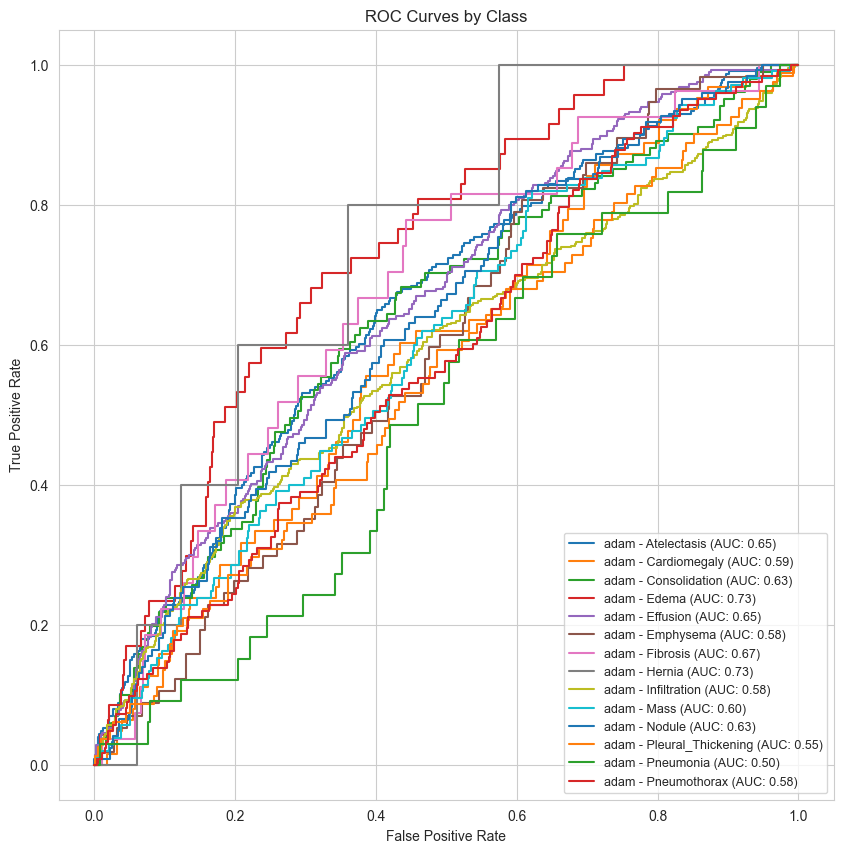

In [48]:
from sklearn.metrics import roc_curve, auc
# Plotting ROC Curves for each class and each optimizer
fig, ax = plt.subplots(figsize=(10, 10))

# Loop through each optimizer's results
for optimizer_name, data in optimizer_results.items():
    predictions = data['predictions']  # Retrieve the stored predictions
    # Loop through each disease label
    for idx, c_label in enumerate(all_labels):
        fpr, tpr, thresholds = roc_curve(test_Y[:, idx].astype(int), predictions[:, idx])
        auc_score = auc(fpr, tpr)
        ax.plot(fpr, tpr, label=f"{optimizer_name} - {c_label} (AUC: {auc_score:.2f})")

ax.set_title('ROC Curves by Class')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(loc='lower right', prop={'size': 9})  # Adjust legend size for readability
plt.show()


## MobileNet + ImageWeight

In [34]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
from keras import optimizers, callbacks, regularizers
base_mobilenet_model = MobileNet(input_shape =  t_x_rgb.shape[1:],
                                 include_top = False, weights = "imagenet")
model1a = Sequential()
model1a.add(base_mobilenet_model)
model1a.add(GlobalAveragePooling2D())
model1a.add(Dropout(0.5))
model1a.add(Dense(512))
model1a.add(Dropout(0.5))
model1a.add(Dense(len(all_labels), activation = 'sigmoid'))
model1a.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
model1a.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_128 (Functional) │ (None, 4, 4, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 14)             │         7,182 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,760,846 (14.35 MB)

 Trainable params: 3,738,958 (14.26 MB)

 Non-trainable params: 21,888 (85.50 KB)

Training with optimizer: adam


c:\Users\keat.siewwk\AppData\Local\anaconda3\envs\myenv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.8361 - loss: 0.5655 - mae: 0.1916
Epoch 1: val_loss improved from inf to 0.80761, saving model to model1a_weights.best.weights.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 321s 3s/step - binary_accuracy: 0.8364 - loss: 0.5642 - mae: 0.1915 - val_binary_accuracy: 0.8858 - val_loss: 0.8076 - val_mae: 0.1159
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - binary_accuracy: 0.8843 - loss: 0.3136 - mae: 0.1779
Epoch 2: val_loss improved from 0.80761 to 0.50702, saving model to model1a_weights.best.weights.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 298s 3s/step - binary_accuracy: 0.8843 - loss: 0.3136 - mae: 0.1779 - val_binary_accuracy: 0.8853 - val_loss: 0.5070 - val_mae: 0.1231
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - binary_accuracy: 0.8792 - loss: 0.3105 - mae: 0.1796
Epoch 3: val_loss improved from 0.50702 to 0.35579, saving model to model1a_weights.best.weights.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 313s 3s/step - binary_accurac

c:\Users\keat.siewwk\AppData\Local\anaconda3\envs\myenv\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 9: val_loss did not improve from 0.29519
100/100 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - binary_accuracy: 0.8888 - loss: 0.2907 - mae: 0.1708 - val_binary_accuracy: 0.8841 - val_loss: 0.3548 - val_mae: 0.1357
Epoch 10/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 971ms/step - binary_accuracy: 0.8870 - loss: 0.2911 - mae: 0.1731
Epoch 10: val_loss improved from 0.29519 to 0.28411, saving model to model1a_weights.best.weights.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 164s 2s/step - binary_accuracy: 0.8870 - loss: 0.2911 - mae: 0.1730 - val_binary_accuracy: 0.8904 - val_loss: 0.2841 - val_mae: 0.1566
Epoch 11/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 695ms/step - binary_accuracy: 0.8900 - loss: 0.2826 - mae: 0.1658
Epoch 11: val_loss did not improve from 0.28411
100/100 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - binary_accuracy: 0.8900 - loss: 0.2826 - mae: 0.1658 - val_binary_accuracy: 0.8895 - val_loss: 0.2898 - val_mae: 0.1533
Epoch 12/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 725ms/step - binary_accuracy: 0.8911 - loss: 0.

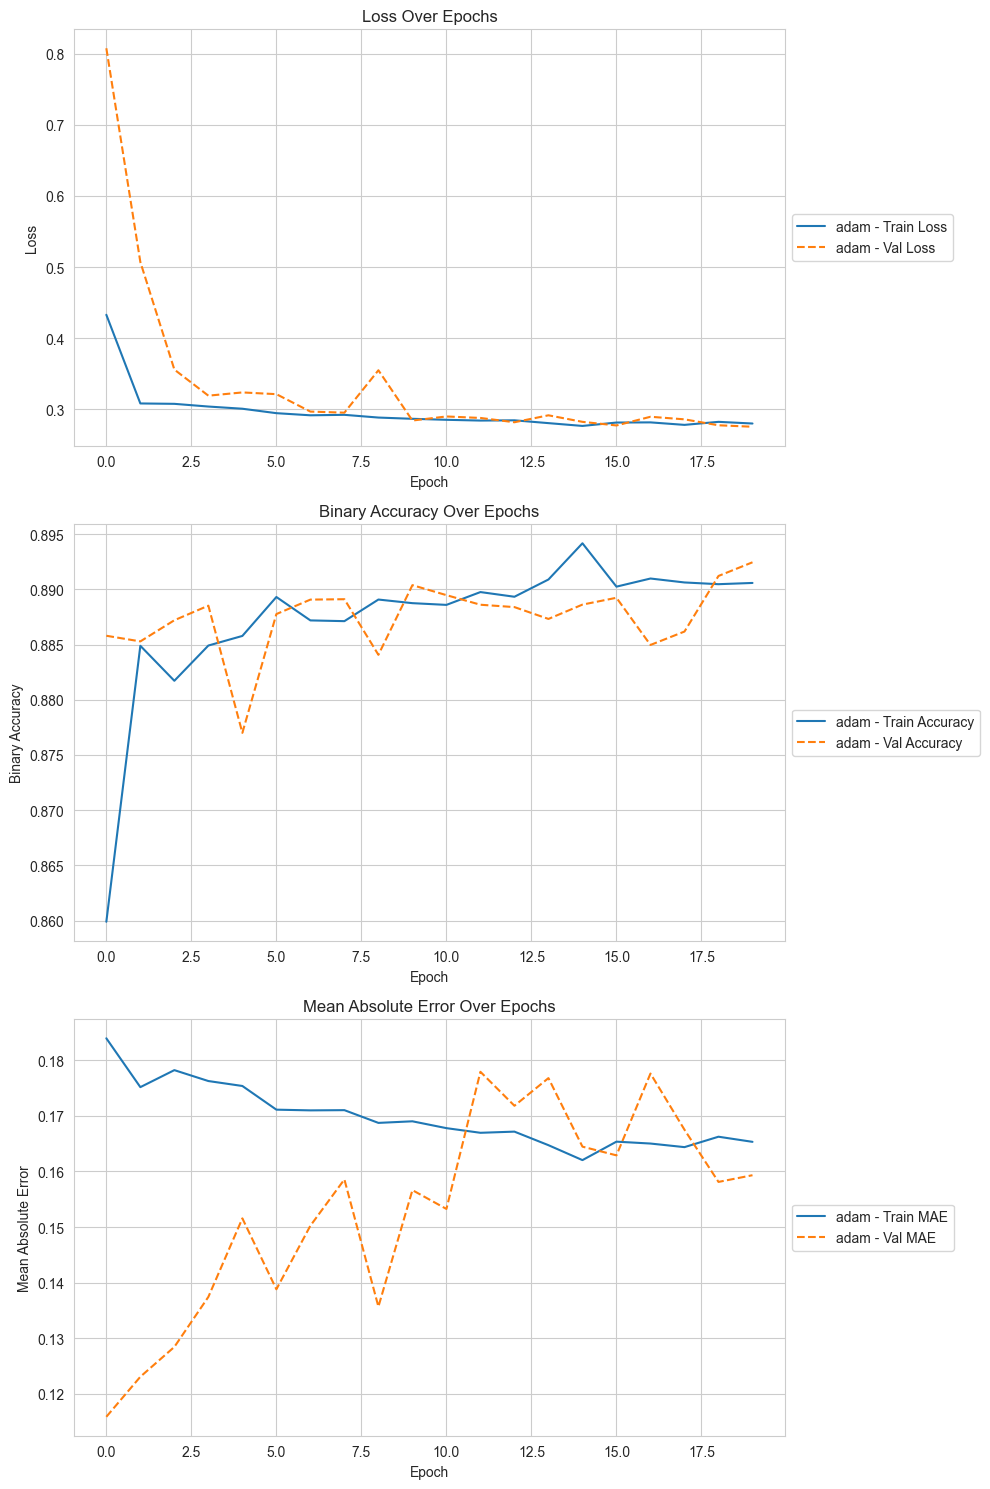

In [36]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

optimizers_list = [
    # ('sgd', optimizers.SGD(learning_rate=0.1)),
    # ('sgd_momentum', optimizers.SGD(learning_rate=0.1, momentum=0.9)),
    # ('adagrad', optimizers.Adagrad()),
    # ('adadelta', optimizers.Adadelta()),
    ('adam', optimizers.Adam())
]


weight_path = "{}_weights.best.weights.h5".format('model1a')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=5)
callbacks_list = [checkpoint, early]


# Dictionary to store metrics for each optimizer
optimizer_results = {}

# Assuming model1, train_gen, test_X, test_Y, and callbacks_list are defined
for optimizer in optimizers_list:
    print(f"Training with optimizer: {optimizer[0]}")
    model1a.compile(optimizer=optimizer[1], loss='binary_crossentropy',
                                metrics=['binary_accuracy', 'mae'])

    history = model1a.fit(train_gen_rgb,
                                      steps_per_epoch=100,
                                      validation_data=valid_gen_rgb,
                                      validation_steps=validation_steps,
                                      epochs=20,
                                      callbacks=callbacks_list)
    print("Available history keys:", history.history.keys())  # Debug statement
    # Store the history
    predictions = model1a.predict(test_X_rgb, batch_size=32, verbose=True)
    optimizer_results[optimizer[0]] = {
        'history': history.history,
        'predictions': predictions
    }

    print(f"{optimizer[0]} training completed.")

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# Plot 1: Loss
for optimizer_name, optimizer_data in optimizer_results.items():
    history = optimizer_data['history']
    if 'loss' in history and 'val_loss' in history:
        axes[0].plot(history['loss'], label=f"{optimizer_name} - Train Loss")
        axes[0].plot(history['val_loss'], linestyle="--", label=f"{optimizer_name} - Val Loss")
    else:
        print(f"Loss data not found for optimizer: {optimizer_name}")

axes[0].set_title("Loss Over Epochs")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes[0].grid(True)

# Plot 2: Binary Accuracy
for optimizer_name, optimizer_data in optimizer_results.items():
    history = optimizer_data['history']
    if 'binary_accuracy' in history and 'val_binary_accuracy' in history:
        axes[1].plot(history['binary_accuracy'], label=f"{optimizer_name} - Train Accuracy")
        axes[1].plot(history['val_binary_accuracy'], linestyle="--", label=f"{optimizer_name} - Val Accuracy")
    else:
        print(f"Binary accuracy data not found for optimizer: {optimizer_name}")

axes[1].set_title("Binary Accuracy Over Epochs")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Binary Accuracy")
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes[1].grid(True)

# Plot 3: Mean Absolute Error
for optimizer_name, optimizer_data in optimizer_results.items():
    history = optimizer_data['history']
    if 'mae' in history and 'val_mae' in history:
        axes[2].plot(history['mae'], label=f"{optimizer_name} - Train MAE")
        axes[2].plot(history['val_mae'], linestyle="--", label=f"{optimizer_name} - Val MAE")
    else:
        print(f"MAE data not found for optimizer: {optimizer_name}")

axes[2].set_title("Mean Absolute Error Over Epochs")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Mean Absolute Error")
axes[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes[2].grid(True)

plt.tight_layout()
plt.show()

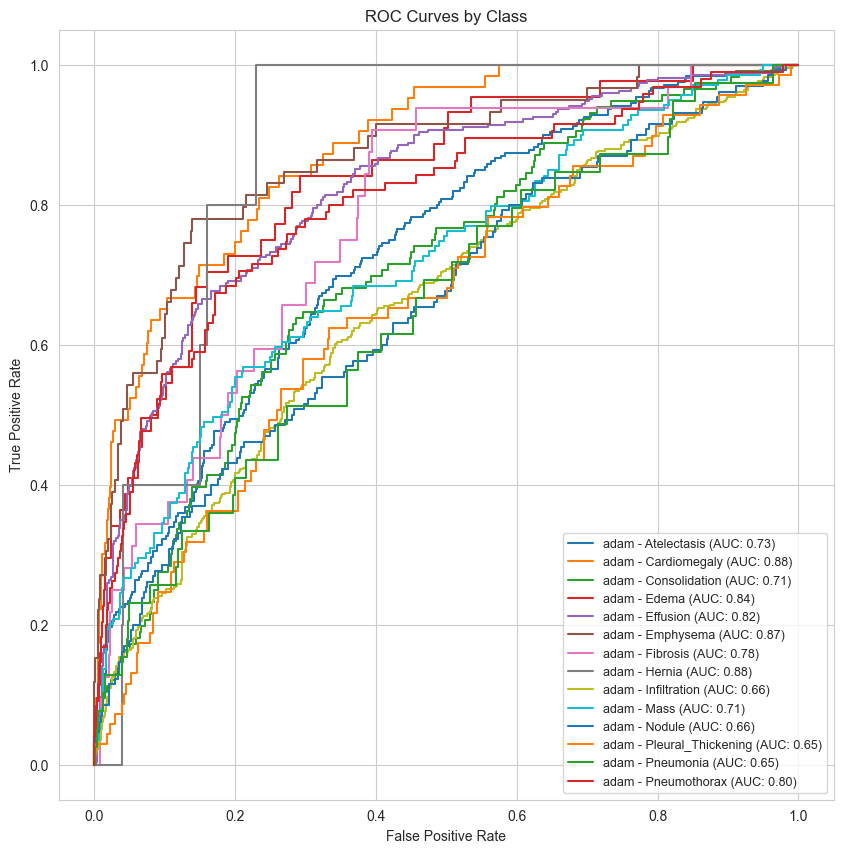

In [37]:
from sklearn.metrics import roc_curve, auc
# Plotting ROC Curves for each class and each optimizer
fig, ax = plt.subplots(figsize=(10, 10))

# Loop through each optimizer's results
for optimizer_name, data in optimizer_results.items():
    predictions = data['predictions']  # Retrieve the stored predictions
    # Loop through each disease label
    for idx, c_label in enumerate(all_labels):
        fpr, tpr, thresholds = roc_curve(test_Y_rgb[:, idx].astype(int), predictions[:, idx])
        auc_score = auc(fpr, tpr)
        ax.plot(fpr, tpr, label=f"{optimizer_name} - {c_label} (AUC: {auc_score:.2f})")

ax.set_title('ROC Curves by Class')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(loc='lower right', prop={'size': 9})  # Adjust legend size for readability
plt.show()


## Custom Model

Training with optimizer: adam
Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 646ms/step - binary_accuracy: 0.8623 - loss: 0.3745 - mae: 0.2232
Epoch 1: val_loss improved from inf to 0.31378, saving model to model2_weights.best.weights.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - binary_accuracy: 0.8624 - loss: 0.3741 - mae: 0.2229 - val_binary_accuracy: 0.8858 - val_loss: 0.3138 - val_mae: 0.2037
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 635ms/step - binary_accuracy: 0.8862 - loss: 0.3129 - mae: 0.1848
Epoch 2: val_loss did not improve from 0.31378
100/100 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - binary_accuracy: 0.8862 - loss: 0.3129 - mae: 0.1848 - val_binary_accuracy: 0.8857 - val_loss: 0.3165 - val_mae: 0.2122
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 664ms/step - binary_accuracy: 0.8847 - loss: 0.3128 - mae: 0.1849
Epoch 3: val_loss improved from 0.31378 to 0.30874, saving model to model2_weights.best.weights.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - binary_accuracy: 0.8847 - loss

c:\Users\keat.siewwk\AppData\Local\anaconda3\envs\myenv\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 9: val_loss did not improve from 0.30182
100/100 ━━━━━━━━━━━━━━━━━━━━ 96s 966ms/step - binary_accuracy: 0.8851 - loss: 0.3048 - mae: 0.1788 - val_binary_accuracy: 0.8860 - val_loss: 0.3025 - val_mae: 0.1846
Epoch 10/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - binary_accuracy: 0.8854 - loss: 0.3036 - mae: 0.1787
Epoch 10: val_loss improved from 0.30182 to 0.30054, saving model to model2_weights.best.weights.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - binary_accuracy: 0.8854 - loss: 0.3036 - mae: 0.1787 - val_binary_accuracy: 0.8859 - val_loss: 0.3005 - val_mae: 0.1769
Epoch 11/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - binary_accuracy: 0.8848 - loss: 0.3038 - mae: 0.1784
Epoch 11: val_loss improved from 0.30054 to 0.29857, saving model to model2_weights.best.weights.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - binary_accuracy: 0.8848 - loss: 0.3038 - mae: 0.1783 - val_binary_accuracy: 0.8858 - val_loss: 0.2986 - val_mae: 0.1841
Epoch 12/20
100/100 ━━━━━━━━━━━━━━━━━━

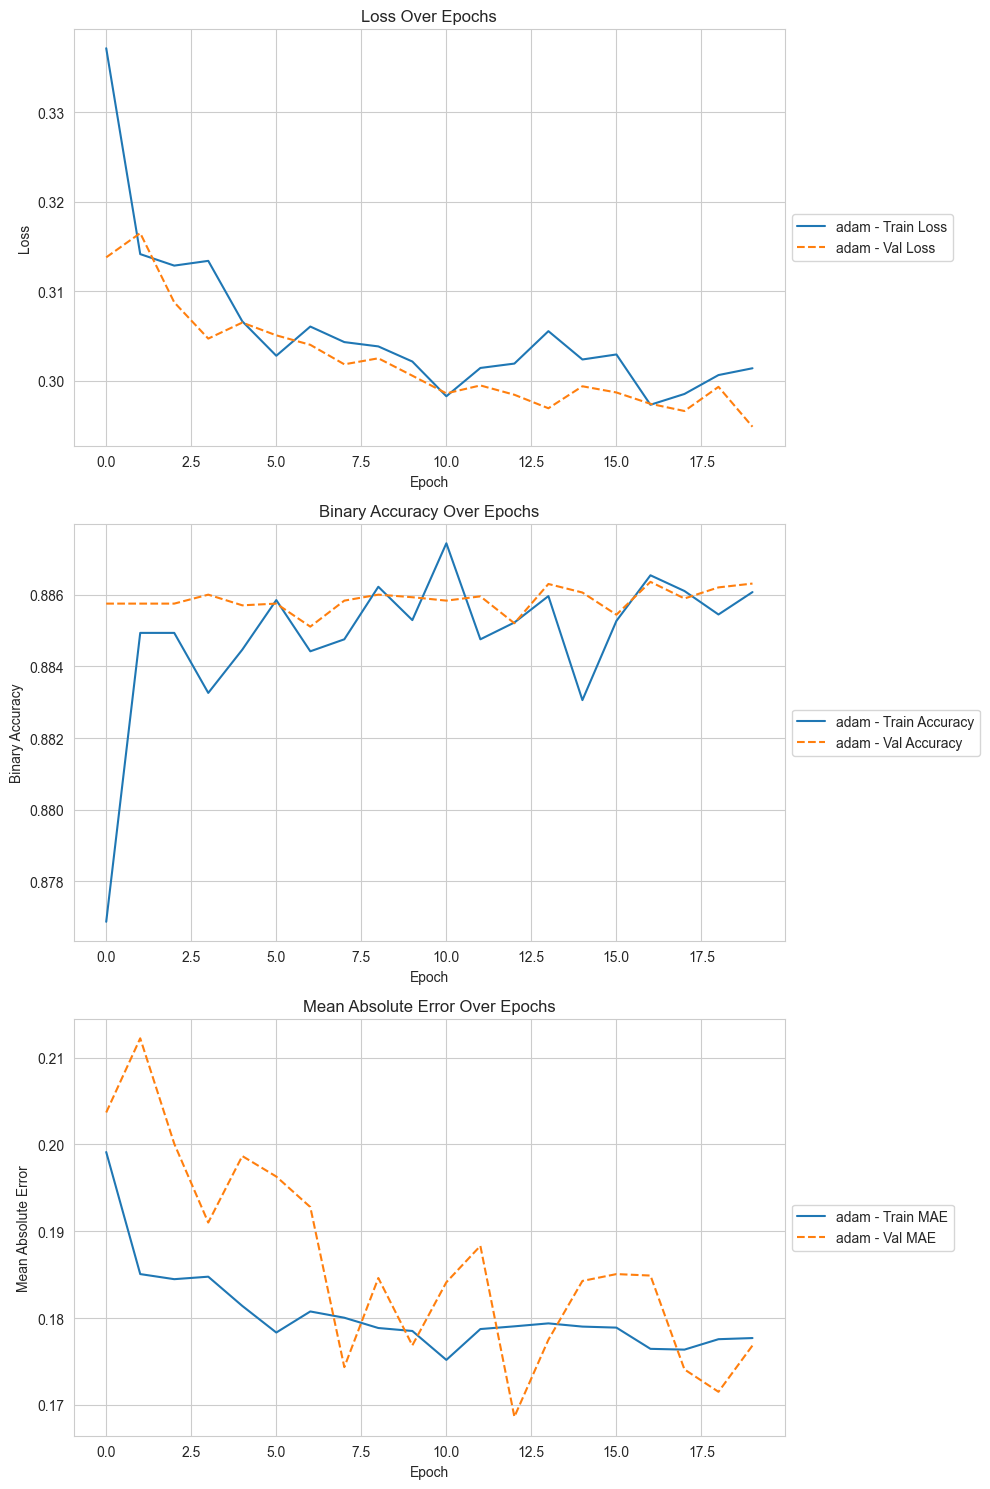

In [41]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
optimizers_list = [
    # ('sgd', optimizers.SGD(learning_rate=0.1)),
    # ('sgd_momentum', optimizers.SGD(learning_rate=0.1, momentum=0.9)),
    # ('adagrad', optimizers.Adagrad()),
    # ('adadelta', optimizers.Adadelta()),
    ('adam', optimizers.Adam())
]

weight_path = "{}_weights.best.weights.h5".format('model2')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=5)
callbacks_list = [checkpoint, early]


# Dictionary to store metrics for each optimizer
optimizer_results = {}

# Assuming model1, train_gen, test_X, test_Y, and callbacks_list are defined
for optimizer in optimizers_list:
    print(f"Training with optimizer: {optimizer[0]}")
    model2.compile(optimizer=optimizer[1], loss='binary_crossentropy',
                                metrics=['binary_accuracy', 'mae'])

    history = model2.fit(train_gen,
                                      steps_per_epoch=100,
                                      validation_data=valid_gen,
                                      validation_steps=validation_steps,
                                      epochs=20,
                                      callbacks=callbacks_list)
    print("Available history keys:", history.history.keys())  # Debug statement
    # Store the history
    predictions = model2.predict(test_X, batch_size=32, verbose=True)
    optimizer_results[optimizer[0]] = {
        'history': history.history,
        'predictions': predictions
    }

    print(f"{optimizer[0]} training completed.")

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# Plot 1: Loss
for optimizer_name, optimizer_data in optimizer_results.items():
    history = optimizer_data['history']
    if 'loss' in history and 'val_loss' in history:
        axes[0].plot(history['loss'], label=f"{optimizer_name} - Train Loss")
        axes[0].plot(history['val_loss'], linestyle="--", label=f"{optimizer_name} - Val Loss")
    else:
        print(f"Loss data not found for optimizer: {optimizer_name}")

axes[0].set_title("Loss Over Epochs")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes[0].grid(True)

# Plot 2: Binary Accuracy
for optimizer_name, optimizer_data in optimizer_results.items():
    history = optimizer_data['history']
    if 'binary_accuracy' in history and 'val_binary_accuracy' in history:
        axes[1].plot(history['binary_accuracy'], label=f"{optimizer_name} - Train Accuracy")
        axes[1].plot(history['val_binary_accuracy'], linestyle="--", label=f"{optimizer_name} - Val Accuracy")
    else:
        print(f"Binary accuracy data not found for optimizer: {optimizer_name}")

axes[1].set_title("Binary Accuracy Over Epochs")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Binary Accuracy")
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes[1].grid(True)

# Plot 3: Mean Absolute Error
for optimizer_name, optimizer_data in optimizer_results.items():
    history = optimizer_data['history']
    if 'mae' in history and 'val_mae' in history:
        axes[2].plot(history['mae'], label=f"{optimizer_name} - Train MAE")
        axes[2].plot(history['val_mae'], linestyle="--", label=f"{optimizer_name} - Val MAE")
    else:
        print(f"MAE data not found for optimizer: {optimizer_name}")

axes[2].set_title("Mean Absolute Error Over Epochs")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Mean Absolute Error")
axes[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes[2].grid(True)

plt.tight_layout()
plt.show()

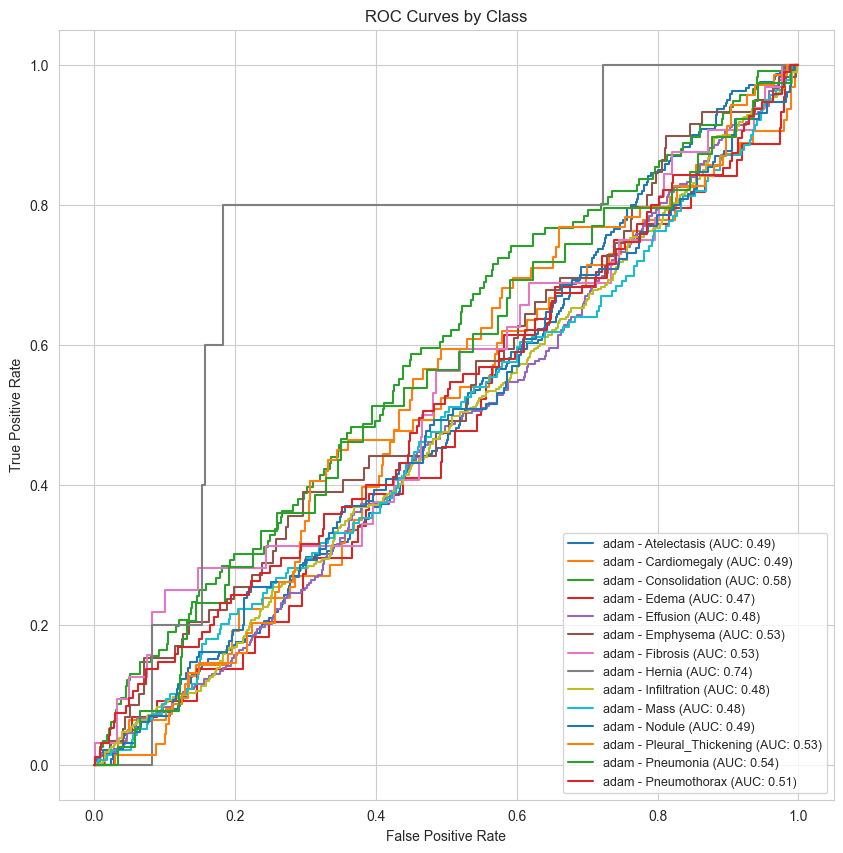

In [43]:
from sklearn.metrics import roc_curve, auc
# Plotting ROC Curves for each class and each optimizer
fig, ax = plt.subplots(figsize=(10, 10))

# Loop through each optimizer's results
for optimizer_name, data in optimizer_results.items():
    predictions = data['predictions']  # Retrieve the stored predictions
    # Loop through each disease label
    for idx, c_label in enumerate(all_labels):
        fpr, tpr, thresholds = roc_curve(test_Y_rgb[:, idx].astype(int), predictions[:, idx])
        auc_score = auc(fpr, tpr)
        ax.plot(fpr, tpr, label=f"{optimizer_name} - {c_label} (AUC: {auc_score:.2f})")

ax.set_title('ROC Curves by Class')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(loc='lower right', prop={'size': 9})  # Adjust legend size for readability
plt.show()
